# LightGBM Baseline
A great idea from DATAMANYO: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

Thanks to her and all the participants who share their ideas.

In [1]:
import pandas as pd, numpy as np, gc
from sklearn.model_selection import KFold ,GroupKFold
from lightgbm import LGBMClassifier 
from sklearn.metrics import f1_score

# Load Train Data and Labels

Instead of working on the total train size is 4.7GB, we shrink it into 10 pieces and the feature engineer will read each piece in order.

In [2]:
tmp = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')
PIECES = 10
CHUNK = int( np.ceil(len(tmp)/PIECES) )

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(tmp): b=len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'We do this step to avoid memory error')

We do this step to avoid memory error


In [3]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', nrows=reads[0])
print('Train size of first piece:', train.shape )
train.head()

Train size of first piece: (2684191, 20)


session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   
1  20090312431273200      1          1323    person_click  basic      0   NaN   
2  20090312431273200      2           831    person_click  basic      0   NaN   
3  20090312431273200      3          1147    person_click  basic      0   NaN   
4  20090312431273200      4          1863    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991405  -159.314686          380.0          494.0             NaN   
1  -413.991405  -159.314686          380.0          494.0             NaN   
2  -413.991405  -159.314686          380.0          494.0             NaN   
3  -413.991405  -159.314686          380.0          494.0             NaN   
4  -412.991405  -159.314686          381.0          494.0             NaN   

                            text    fqid                       room_fqid  \
0                      undefined   intro  tunic.historicalsociety.closet   
1  Whatcha doing over there, Jo?  gramps  tunic.historicalsociety.closet   
2         Just talking to Teddy.  gramps  tunic.historicalsociety.closet   
3     I gotta run to my meeting!  gramps  tunic.historicalsociety.closet   
4            Can I come, Gramps?  gramps  tunic.historicalsociety.closet   

                                           text_fqid  fullscreen  hq  music  \
0               tunic.historicalsociety.closet.intro           0   0      1   
1  tunic.historicalsociety.closet.gramps.intro_0_...           0   0      1   
2  tunic.historicalsociety.closet.gramps.intro_0_...           0   0      1   
3  tunic.historicalsociety.closet.gramps.intro_0_...           0   0      1   
4  tunic.historicalsociety.closet.gramps.intro_0_...           0   0      1   

  level_group  
0         0-4  
1         0-4  
2         0-4  
3         0-4  
4         0-4

In [4]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(424116, 4)


session_id  correct            session  q
0  20090312431273200_q1        1  20090312431273200  1
1  20090312433251036_q1        0  20090312433251036  1
2  20090312455206810_q1        1  20090312455206810  1
3  20090313091715820_q1        0  20090313091715820  1
4  20090313571836404_q1        1  20090313571836404  1

# Feature Engineer
We create basic aggregate features. We think event is important factor for prediction.

[1]: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

In [5]:
CATS = ['event_name','name', 'fqid', 'room_fqid', 'text']

NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [6]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [7]:
df_tr = feature_engineer(train)
print(df_tr.shape)

(7071, 32)


In [8]:
%%time

# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()

Processing train as 10 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

Shape of all train data after feature engineering: (70686, 32)
CPU times: user 3min 59s, sys: 10.1 s, total: 4min 9s
Wall time: 4min 28s


level_group  event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                                      
20090312431273200         0-4                  10             3            30   
20090312431273200       13-22                  10             3            49   
20090312431273200        5-12                  10             3            39   
20090312433251036         0-4                  11             4            22   
20090312433251036       13-22                  11             6            73   

                   room_fqid_nunique  text_nunique  elapsed_time_mean  \
session_id                                                              
20090312431273200                  7            56       8.579356e+04   
20090312431273200                 12           168       1.040601e+06   
20090312431273200                 11           124       3.572052e+05   
20090312433251036                  6            49       9.763342e+04   
20090312433251036                 16           183       2.498852e+06   

                   level_mean  page_mean  room_coor_x_mean  ...  \
session_id                                                  ...   
20090312431273200    1.945455       -1.0          7.701275  ...   
20090312431273200   17.402381       -1.0       -130.347170  ...   
20090312431273200    8.054054       -1.0         14.306062  ...   
20090312433251036    1.870504        0.0        -84.045960  ...   
20090312433251036   17.762529        5.1        -30.762282  ...   

                   navigate_click_sum  person_click_sum  cutscene_click_sum  \
session_id                                                                    
20090312431273200                81.0              22.0                28.0   
20090312431273200               170.0             123.0                60.0   
20090312431273200               103.0             104.0                12.0   
20090312433251036                49.0              18.0                36.0   
20090312433251036               637.0             145.0                65.0   

                   object_click_sum  map_hover_sum  notification_click_sum  \
session_id                                                                   
20090312431273200              11.0            4.0                       8   
20090312431273200              20.0           14.0                      10   
20090312431273200              28.0            9.0                       9   
20090312433251036              15.0            3.0                       5   
20090312433251036              83.0          186.0                      14   

                   map_click_sum  observation_click_sum  checkpoint_sum  \
session_id                                                                
20090312431273200            2.0                      4               1   
20090312431273200            6.0                      3               1   
20090312431273200            8.0                      1               1   
20090312433251036            3.0                      2               1   
20090312433251036           45.0                      5               1   

                   elapsed_time_sum  
session_id                           
20090312431273200          14155937  
20090312431273200         437052322  
20090312431273200         105732736  
20090312433251036          13571045  
20090312433251036        3241011333  

[5 rows x 32 columns]

# Train LightGBM Model
For each of the 18 questions, we train one model. In addition, we use data from `level_groups = '0-4'`. to train the model for questions 1-3, `level groups '5-12'` to train questions 4-13, and `level groups '13-22'` to train questions 14-18. Because this is the data we acquire from Kaggle's inference API during test inference (to predict corresponding questions). We may improve our model by preserving a user's historical data from previous `level_groups` and utilizing it to forecast future `level_groups`.

In [9]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 31 features
We will train with 23562 users info


# Hyperparameters Tuning
We fine tune the hyperparameters to get the best results.

In [10]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    lgb_params = {
    'objective' : 'binary',
    'learning_rate': 0.002,
    'max_depth': 6,
    'num_iterations': 1000
    }
    
    #'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  LGBMClassifier(**lgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , [1]	valid_0's binary_logloss: 0.594409


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[2]	valid_0's binary_logloss: 0.594288
[3]	valid_0's binary_logloss: 0.594168
[4]	valid_0's binary_logloss: 0.594049
[5]	valid_0's binary_logloss: 0.59393
[6]	valid_0's binary_logloss: 0.593812
[7]	valid_0's binary_logloss: 0.593693
[8]	valid_0's binary_logloss: 0.593575
[9]	valid_0's binary_logloss: 0.593456
[10]	valid_0's binary_logloss: 0.59334
[11]	valid_0's binary_logloss: 0.593225
[12]	valid_0's binary_logloss: 0.593109
[13]	valid_0's binary_logloss: 0.592997
[14]	valid_0's binary_logloss: 0.592883
[15]	valid_0's binary_logloss: 0.592763
[16]	valid_0's binary_logloss: 0.592652
[17]	valid_0's binary_logloss: 0.592533
[18]	valid_0's binary_logloss: 0.592421
[19]	valid_0's binary_logloss: 0.592301
[20]	valid_0's binary_logloss: 0.592195
[21]	valid_0's binary_logloss: 0.592076
[22]	valid_0's binary_logloss: 0.591962
[23]	valid_0's binary_logloss: 0.591857
[24]	valid_0's binary_logloss: 0.59174
[25]	valid_0's binary_logloss: 0.591627
[26]	valid_0's binary_logloss: 0.59152
[27]	valid_0

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.111298
[13]	valid_0's binary_logloss: 0.11127
[14]	valid_0's binary_logloss: 0.111236
[15]	valid_0's binary_logloss: 0.111197
[16]	valid_0's binary_logloss: 0.111163
[17]	valid_0's binary_logloss: 0.111124
[18]	valid_0's binary_logloss: 0.111095
[19]	valid_0's binary_logloss: 0.111054
[20]	valid_0's binary_logloss: 0.111014
[21]	valid_0's binary_logloss: 0.110982
[22]	valid_0's binary_logloss: 0.110939
[23]	valid_0's binary_logloss: 0.110905
[24]	valid_0's binary_logloss: 0.110858
[25]	valid_0's binary_logloss: 0.110814
[26]	valid_0's binary_logloss: 0.110772
[27]	valid_0's binary_logloss: 0.110725
[28]	valid_0's binary_logloss: 0.110686
[29]	valid_0's binary_logloss: 0.110657
[30]	valid_0's binary_logloss: 0.11063
[31]	valid_0's binary_logloss: 0.110597
[32]	valid_0's binary_logloss: 0.110563
[33]	valid_0's binary_logloss: 0.110531
[34]	valid_0's binary_logloss: 0.110501
[35]	valid_0's binary_logloss: 0.110466
[36]	valid_0's binary_logloss: 0.110437
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.242961
[13]	valid_0's binary_logloss: 0.242903
[14]	valid_0's binary_logloss: 0.24284
[15]	valid_0's binary_logloss: 0.242789
[16]	valid_0's binary_logloss: 0.24273
[17]	valid_0's binary_logloss: 0.242679
[18]	valid_0's binary_logloss: 0.242617
[19]	valid_0's binary_logloss: 0.242558
[20]	valid_0's binary_logloss: 0.242497
[21]	valid_0's binary_logloss: 0.242434
[22]	valid_0's binary_logloss: 0.242367
[23]	valid_0's binary_logloss: 0.242307
[24]	valid_0's binary_logloss: 0.242245
[25]	valid_0's binary_logloss: 0.24219
[26]	valid_0's binary_logloss: 0.242132
[27]	valid_0's binary_logloss: 0.242074
[28]	valid_0's binary_logloss: 0.242017
[29]	valid_0's binary_logloss: 0.241958
[30]	valid_0's binary_logloss: 0.2419
[31]	valid_0's binary_logloss: 0.241839
[32]	valid_0's binary_logloss: 0.241781
[33]	valid_0's binary_logloss: 0.241734
[34]	valid_0's binary_logloss: 0.241675
[35]	valid_0's binary_logloss: 0.241625
[36]	valid_0's binary_logloss: 0.241572
[37]	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.503883
[11]	valid_0's binary_logloss: 0.503696
[12]	valid_0's binary_logloss: 0.503514
[13]	valid_0's binary_logloss: 0.503334
[14]	valid_0's binary_logloss: 0.503154
[15]	valid_0's binary_logloss: 0.502978
[16]	valid_0's binary_logloss: 0.502797
[17]	valid_0's binary_logloss: 0.502622
[18]	valid_0's binary_logloss: 0.502448
[19]	valid_0's binary_logloss: 0.502277
[20]	valid_0's binary_logloss: 0.502105
[21]	valid_0's binary_logloss: 0.501937
[22]	valid_0's binary_logloss: 0.501769
[23]	valid_0's binary_logloss: 0.501599
[24]	valid_0's binary_logloss: 0.501433
[25]	valid_0's binary_logloss: 0.501265
[26]	valid_0's binary_logloss: 0.501101
[27]	valid_0's binary_logloss: 0.500938
[28]	valid_0's binary_logloss: 0.500774
[29]	valid_0's binary_logloss: 0.50061
[30]	valid_0's binary_logloss: 0.500448
[31]	valid_0's binary_logloss: 0.500289
[32]	valid_0's binary_logloss: 0.50013
[33]	valid_0's binary_logloss: 0.499969
[34]	valid_0's binary_logloss: 0.499811
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.689994
[11]	valid_0's binary_logloss: 0.689848
[12]	valid_0's binary_logloss: 0.6897
[13]	valid_0's binary_logloss: 0.689554
[14]	valid_0's binary_logloss: 0.689407
[15]	valid_0's binary_logloss: 0.689263
[16]	valid_0's binary_logloss: 0.689117
[17]	valid_0's binary_logloss: 0.688975
[18]	valid_0's binary_logloss: 0.68883
[19]	valid_0's binary_logloss: 0.688686
[20]	valid_0's binary_logloss: 0.688545
[21]	valid_0's binary_logloss: 0.688403
[22]	valid_0's binary_logloss: 0.688263
[23]	valid_0's binary_logloss: 0.688123
[24]	valid_0's binary_logloss: 0.687984
[25]	valid_0's binary_logloss: 0.687845
[26]	valid_0's binary_logloss: 0.687707
[27]	valid_0's binary_logloss: 0.687569
[28]	valid_0's binary_logloss: 0.687433
[29]	valid_0's binary_logloss: 0.687297
[30]	valid_0's binary_logloss: 0.68716
[31]	valid_0's binary_logloss: 0.687025
[32]	valid_0's binary_logloss: 0.68689
[33]	valid_0's binary_logloss: 0.686755
[34]	valid_0's binary_logloss: 0.686621
[35]	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.527774
[13]	valid_0's binary_logloss: 0.527617
[14]	valid_0's binary_logloss: 0.527467
[15]	valid_0's binary_logloss: 0.527313
[16]	valid_0's binary_logloss: 0.527165
[17]	valid_0's binary_logloss: 0.527015
[18]	valid_0's binary_logloss: 0.52686
[19]	valid_0's binary_logloss: 0.526714
[20]	valid_0's binary_logloss: 0.526567
[21]	valid_0's binary_logloss: 0.526417
[22]	valid_0's binary_logloss: 0.526268
[23]	valid_0's binary_logloss: 0.526123
[24]	valid_0's binary_logloss: 0.525975
[25]	valid_0's binary_logloss: 0.525825
[26]	valid_0's binary_logloss: 0.525684
[27]	valid_0's binary_logloss: 0.525538
[28]	valid_0's binary_logloss: 0.525395
[29]	valid_0's binary_logloss: 0.525251
[30]	valid_0's binary_logloss: 0.525112
[31]	valid_0's binary_logloss: 0.524971
[32]	valid_0's binary_logloss: 0.52483
[33]	valid_0's binary_logloss: 0.524688
[34]	valid_0's binary_logloss: 0.524546
[35]	valid_0's binary_logloss: 0.524402
[36]	valid_0's binary_logloss: 0.524263
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.585398
[11]	valid_0's binary_logloss: 0.5853
[12]	valid_0's binary_logloss: 0.585206
[13]	valid_0's binary_logloss: 0.585109
[14]	valid_0's binary_logloss: 0.585018
[15]	valid_0's binary_logloss: 0.584921
[16]	valid_0's binary_logloss: 0.584824
[17]	valid_0's binary_logloss: 0.584731
[18]	valid_0's binary_logloss: 0.584636
[19]	valid_0's binary_logloss: 0.584544
[20]	valid_0's binary_logloss: 0.584448
[21]	valid_0's binary_logloss: 0.584354
[22]	valid_0's binary_logloss: 0.58426
[23]	valid_0's binary_logloss: 0.584166
[24]	valid_0's binary_logloss: 0.584069
[25]	valid_0's binary_logloss: 0.583979
[26]	valid_0's binary_logloss: 0.583884
[27]	valid_0's binary_logloss: 0.583793
[28]	valid_0's binary_logloss: 0.583699
[29]	valid_0's binary_logloss: 0.583608
[30]	valid_0's binary_logloss: 0.583519
[31]	valid_0's binary_logloss: 0.583428
[32]	valid_0's binary_logloss: 0.583334
[33]	valid_0's binary_logloss: 0.583248
[34]	valid_0's binary_logloss: 0.583152
[35

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.66273
[12]	valid_0's binary_logloss: 0.662686
[13]	valid_0's binary_logloss: 0.662645
[14]	valid_0's binary_logloss: 0.662602
[15]	valid_0's binary_logloss: 0.662563
[16]	valid_0's binary_logloss: 0.66252
[17]	valid_0's binary_logloss: 0.662478
[18]	valid_0's binary_logloss: 0.662439
[19]	valid_0's binary_logloss: 0.662401
[20]	valid_0's binary_logloss: 0.66236
[21]	valid_0's binary_logloss: 0.662321
[22]	valid_0's binary_logloss: 0.662285
[23]	valid_0's binary_logloss: 0.662247
[24]	valid_0's binary_logloss: 0.662206
[25]	valid_0's binary_logloss: 0.662168
[26]	valid_0's binary_logloss: 0.662131
[27]	valid_0's binary_logloss: 0.662093
[28]	valid_0's binary_logloss: 0.662056
[29]	valid_0's binary_logloss: 0.662017
[30]	valid_0's binary_logloss: 0.661977
[31]	valid_0's binary_logloss: 0.66194
[32]	valid_0's binary_logloss: 0.661903
[33]	valid_0's binary_logloss: 0.661864
[34]	valid_0's binary_logloss: 0.661825
[35]	valid_0's binary_logloss: 0.661788
[36]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.576349
[12]	valid_0's binary_logloss: 0.57622
[13]	valid_0's binary_logloss: 0.576094
[14]	valid_0's binary_logloss: 0.575969
[15]	valid_0's binary_logloss: 0.57584
[16]	valid_0's binary_logloss: 0.575717
[17]	valid_0's binary_logloss: 0.575593
[18]	valid_0's binary_logloss: 0.575469
[19]	valid_0's binary_logloss: 0.575349
[20]	valid_0's binary_logloss: 0.575225
[21]	valid_0's binary_logloss: 0.575107
[22]	valid_0's binary_logloss: 0.574986
[23]	valid_0's binary_logloss: 0.574865
[24]	valid_0's binary_logloss: 0.574745
[25]	valid_0's binary_logloss: 0.57463
[26]	valid_0's binary_logloss: 0.574518
[27]	valid_0's binary_logloss: 0.574402
[28]	valid_0's binary_logloss: 0.574284
[29]	valid_0's binary_logloss: 0.57417
[30]	valid_0's binary_logloss: 0.574053
[31]	valid_0's binary_logloss: 0.573937
[32]	valid_0's binary_logloss: 0.573825
[33]	valid_0's binary_logloss: 0.573709
[34]	valid_0's binary_logloss: 0.573588
[35]	valid_0's binary_logloss: 0.57347
[36]	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.691655
[11]	valid_0's binary_logloss: 0.691521
[12]	valid_0's binary_logloss: 0.69139
[13]	valid_0's binary_logloss: 0.691258
[14]	valid_0's binary_logloss: 0.69113
[15]	valid_0's binary_logloss: 0.690999
[16]	valid_0's binary_logloss: 0.690869
[17]	valid_0's binary_logloss: 0.69074
[18]	valid_0's binary_logloss: 0.690613
[19]	valid_0's binary_logloss: 0.690484
[20]	valid_0's binary_logloss: 0.690357
[21]	valid_0's binary_logloss: 0.690228
[22]	valid_0's binary_logloss: 0.690109
[23]	valid_0's binary_logloss: 0.689985
[24]	valid_0's binary_logloss: 0.689866
[25]	valid_0's binary_logloss: 0.689749
[26]	valid_0's binary_logloss: 0.689623
[27]	valid_0's binary_logloss: 0.689507
[28]	valid_0's binary_logloss: 0.689391
[29]	valid_0's binary_logloss: 0.689269
[30]	valid_0's binary_logloss: 0.689151
[31]	valid_0's binary_logloss: 0.689036
[32]	valid_0's binary_logloss: 0.688913
[33]	valid_0's binary_logloss: 0.688801
[34]	valid_0's binary_logloss: 0.688679
[35

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.657212
[12]	valid_0's binary_logloss: 0.65713
[13]	valid_0's binary_logloss: 0.657049
[14]	valid_0's binary_logloss: 0.656964
[15]	valid_0's binary_logloss: 0.656883
[16]	valid_0's binary_logloss: 0.656803
[17]	valid_0's binary_logloss: 0.656715
[18]	valid_0's binary_logloss: 0.656637
[19]	valid_0's binary_logloss: 0.656554
[20]	valid_0's binary_logloss: 0.656471
[21]	valid_0's binary_logloss: 0.65639
[22]	valid_0's binary_logloss: 0.656312
[23]	valid_0's binary_logloss: 0.656232
[24]	valid_0's binary_logloss: 0.656152
[25]	valid_0's binary_logloss: 0.656072
[26]	valid_0's binary_logloss: 0.655994
[27]	valid_0's binary_logloss: 0.655914
[28]	valid_0's binary_logloss: 0.655835
[29]	valid_0's binary_logloss: 0.655758
[30]	valid_0's binary_logloss: 0.655679
[31]	valid_0's binary_logloss: 0.6556
[32]	valid_0's binary_logloss: 0.655526
[33]	valid_0's binary_logloss: 0.655446
[34]	valid_0's binary_logloss: 0.655369
[35]	valid_0's binary_logloss: 0.655296
[36]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.400839
[12]	valid_0's binary_logloss: 0.400775
[13]	valid_0's binary_logloss: 0.400712
[14]	valid_0's binary_logloss: 0.400656
[15]	valid_0's binary_logloss: 0.400594
[16]	valid_0's binary_logloss: 0.400532
[17]	valid_0's binary_logloss: 0.400477
[18]	valid_0's binary_logloss: 0.400416
[19]	valid_0's binary_logloss: 0.400356
[20]	valid_0's binary_logloss: 0.400298
[21]	valid_0's binary_logloss: 0.400243
[22]	valid_0's binary_logloss: 0.400184
[23]	valid_0's binary_logloss: 0.40013
[24]	valid_0's binary_logloss: 0.400073
[25]	valid_0's binary_logloss: 0.400022
[26]	valid_0's binary_logloss: 0.39997
[27]	valid_0's binary_logloss: 0.399913
[28]	valid_0's binary_logloss: 0.399862
[29]	valid_0's binary_logloss: 0.399806
[30]	valid_0's binary_logloss: 0.399757
[31]	valid_0's binary_logloss: 0.399702
[32]	valid_0's binary_logloss: 0.399651
[33]	valid_0's binary_logloss: 0.399599
[34]	valid_0's binary_logloss: 0.399547
[35]	valid_0's binary_logloss: 0.399496
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.581279
[12]	valid_0's binary_logloss: 0.581138
[13]	valid_0's binary_logloss: 0.580999
[14]	valid_0's binary_logloss: 0.580859
[15]	valid_0's binary_logloss: 0.58072
[16]	valid_0's binary_logloss: 0.580583
[17]	valid_0's binary_logloss: 0.580446
[18]	valid_0's binary_logloss: 0.580309
[19]	valid_0's binary_logloss: 0.580174
[20]	valid_0's binary_logloss: 0.580037
[21]	valid_0's binary_logloss: 0.579903
[22]	valid_0's binary_logloss: 0.579764
[23]	valid_0's binary_logloss: 0.579631
[24]	valid_0's binary_logloss: 0.579496
[25]	valid_0's binary_logloss: 0.579362
[26]	valid_0's binary_logloss: 0.579231
[27]	valid_0's binary_logloss: 0.579099
[28]	valid_0's binary_logloss: 0.578968
[29]	valid_0's binary_logloss: 0.578837
[30]	valid_0's binary_logloss: 0.578706
[31]	valid_0's binary_logloss: 0.578577
[32]	valid_0's binary_logloss: 0.578448
[33]	valid_0's binary_logloss: 0.57832
[34]	valid_0's binary_logloss: 0.578192
[35]	valid_0's binary_logloss: 0.578065
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.603117
[12]	valid_0's binary_logloss: 0.602981
[13]	valid_0's binary_logloss: 0.602848
[14]	valid_0's binary_logloss: 0.602714
[15]	valid_0's binary_logloss: 0.602588
[16]	valid_0's binary_logloss: 0.602456
[17]	valid_0's binary_logloss: 0.602334
[18]	valid_0's binary_logloss: 0.602201
[19]	valid_0's binary_logloss: 0.60208
[20]	valid_0's binary_logloss: 0.60195
[21]	valid_0's binary_logloss: 0.601828
[22]	valid_0's binary_logloss: 0.6017
[23]	valid_0's binary_logloss: 0.601579
[24]	valid_0's binary_logloss: 0.601453
[25]	valid_0's binary_logloss: 0.601334
[26]	valid_0's binary_logloss: 0.601214
[27]	valid_0's binary_logloss: 0.601089
[28]	valid_0's binary_logloss: 0.600969
[29]	valid_0's binary_logloss: 0.600844
[30]	valid_0's binary_logloss: 0.600725
[31]	valid_0's binary_logloss: 0.600601
[32]	valid_0's binary_logloss: 0.600483
[33]	valid_0's binary_logloss: 0.600361
[34]	valid_0's binary_logloss: 0.60024
[35]	valid_0's binary_logloss: 0.600124
[36]	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.690121
[13]	valid_0's binary_logloss: 0.689982
[14]	valid_0's binary_logloss: 0.689849
[15]	valid_0's binary_logloss: 0.689711
[16]	valid_0's binary_logloss: 0.689576
[17]	valid_0's binary_logloss: 0.68944
[18]	valid_0's binary_logloss: 0.689307
[19]	valid_0's binary_logloss: 0.689171
[20]	valid_0's binary_logloss: 0.689039
[21]	valid_0's binary_logloss: 0.688905
[22]	valid_0's binary_logloss: 0.688777
[23]	valid_0's binary_logloss: 0.688649
[24]	valid_0's binary_logloss: 0.688523
[25]	valid_0's binary_logloss: 0.688394
[26]	valid_0's binary_logloss: 0.688271
[27]	valid_0's binary_logloss: 0.688147
[28]	valid_0's binary_logloss: 0.68802
[29]	valid_0's binary_logloss: 0.687899
[30]	valid_0's binary_logloss: 0.687777
[31]	valid_0's binary_logloss: 0.687655
[32]	valid_0's binary_logloss: 0.687538
[33]	valid_0's binary_logloss: 0.687419
[34]	valid_0's binary_logloss: 0.687305
[35]	valid_0's binary_logloss: 0.687185
[36]	valid_0's binary_logloss: 0.687064
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[14]	valid_0's binary_logloss: 0.586244
[15]	valid_0's binary_logloss: 0.586223
[16]	valid_0's binary_logloss: 0.586204
[17]	valid_0's binary_logloss: 0.586185
[18]	valid_0's binary_logloss: 0.586165
[19]	valid_0's binary_logloss: 0.586143
[20]	valid_0's binary_logloss: 0.586123
[21]	valid_0's binary_logloss: 0.586105
[22]	valid_0's binary_logloss: 0.586086
[23]	valid_0's binary_logloss: 0.586065
[24]	valid_0's binary_logloss: 0.586046
[25]	valid_0's binary_logloss: 0.586024
[26]	valid_0's binary_logloss: 0.586006
[27]	valid_0's binary_logloss: 0.585989
[28]	valid_0's binary_logloss: 0.585968
[29]	valid_0's binary_logloss: 0.585949
[30]	valid_0's binary_logloss: 0.585929
[31]	valid_0's binary_logloss: 0.585907
[32]	valid_0's binary_logloss: 0.585886
[33]	valid_0's binary_logloss: 0.585867
[34]	valid_0's binary_logloss: 0.585846
[35]	valid_0's binary_logloss: 0.585829
[36]	valid_0's binary_logloss: 0.585809
[37]	valid_0's binary_logloss: 0.585791
[38]	valid_0's binary_logloss: 0.585772


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.633523
[13]	valid_0's binary_logloss: 0.633483
[14]	valid_0's binary_logloss: 0.633436
[15]	valid_0's binary_logloss: 0.633391
[16]	valid_0's binary_logloss: 0.633345
[17]	valid_0's binary_logloss: 0.633306
[18]	valid_0's binary_logloss: 0.633259
[19]	valid_0's binary_logloss: 0.633213
[20]	valid_0's binary_logloss: 0.633173
[21]	valid_0's binary_logloss: 0.633129
[22]	valid_0's binary_logloss: 0.633084
[23]	valid_0's binary_logloss: 0.633037
[24]	valid_0's binary_logloss: 0.632998
[25]	valid_0's binary_logloss: 0.632955
[26]	valid_0's binary_logloss: 0.63291
[27]	valid_0's binary_logloss: 0.632871
[28]	valid_0's binary_logloss: 0.632833
[29]	valid_0's binary_logloss: 0.632792
[30]	valid_0's binary_logloss: 0.632746
[31]	valid_0's binary_logloss: 0.632707
[32]	valid_0's binary_logloss: 0.632669
[33]	valid_0's binary_logloss: 0.632629
[34]	valid_0's binary_logloss: 0.632585
[35]	valid_0's binary_logloss: 0.632546
[36]	valid_0's binary_logloss: 0.632509
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.203106
[14]	valid_0's binary_logloss: 0.20306
[15]	valid_0's binary_logloss: 0.202993
[16]	valid_0's binary_logloss: 0.202932
[17]	valid_0's binary_logloss: 0.202882
[18]	valid_0's binary_logloss: 0.20283
[19]	valid_0's binary_logloss: 0.202771
[20]	valid_0's binary_logloss: 0.202725
[21]	valid_0's binary_logloss: 0.202681
[22]	valid_0's binary_logloss: 0.20263
[23]	valid_0's binary_logloss: 0.202586
[24]	valid_0's binary_logloss: 0.202547
[25]	valid_0's binary_logloss: 0.202495
[26]	valid_0's binary_logloss: 0.202439
[27]	valid_0's binary_logloss: 0.2024
[28]	valid_0's binary_logloss: 0.202341
[29]	valid_0's binary_logloss: 0.2023
[30]	valid_0's binary_logloss: 0.202251
[31]	valid_0's binary_logloss: 0.202213
[32]	valid_0's binary_logloss: 0.202168
[33]	valid_0's binary_logloss: 0.202129
[34]	valid_0's binary_logloss: 0.20208
[35]	valid_0's binary_logloss: 0.202037
[36]	valid_0's binary_logloss: 0.202003
[37]	valid_0's binary_logloss: 0.201965
[38]	val

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.570743
[11]	valid_0's binary_logloss: 0.57064
[12]	valid_0's binary_logloss: 0.570539
[13]	valid_0's binary_logloss: 0.570438
[14]	valid_0's binary_logloss: 0.570334
[15]	valid_0's binary_logloss: 0.570234
[16]	valid_0's binary_logloss: 0.570134
[17]	valid_0's binary_logloss: 0.570036
[18]	valid_0's binary_logloss: 0.569936
[19]	valid_0's binary_logloss: 0.56984
[20]	valid_0's binary_logloss: 0.569742
[21]	valid_0's binary_logloss: 0.569646
[22]	valid_0's binary_logloss: 0.569548
[23]	valid_0's binary_logloss: 0.569453
[24]	valid_0's binary_logloss: 0.569357
[25]	valid_0's binary_logloss: 0.569257
[26]	valid_0's binary_logloss: 0.569161
[27]	valid_0's binary_logloss: 0.569065
[28]	valid_0's binary_logloss: 0.56897
[29]	valid_0's binary_logloss: 0.568874
[30]	valid_0's binary_logloss: 0.56878
[31]	valid_0's binary_logloss: 0.568685
[32]	valid_0's binary_logloss: 0.568589
[33]	valid_0's binary_logloss: 0.568496
[34]	valid_0's binary_logloss: 0.568401
[35]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.0967033
[14]	valid_0's binary_logloss: 0.0966742
[15]	valid_0's binary_logloss: 0.0966551
[16]	valid_0's binary_logloss: 0.0966286
[17]	valid_0's binary_logloss: 0.0966043
[18]	valid_0's binary_logloss: 0.0965809
[19]	valid_0's binary_logloss: 0.0965554
[20]	valid_0's binary_logloss: 0.0965345
[21]	valid_0's binary_logloss: 0.0964996
[22]	valid_0's binary_logloss: 0.0964643
[23]	valid_0's binary_logloss: 0.0964425
[24]	valid_0's binary_logloss: 0.0964103
[25]	valid_0's binary_logloss: 0.0963899
[26]	valid_0's binary_logloss: 0.0963634
[27]	valid_0's binary_logloss: 0.0963327
[28]	valid_0's binary_logloss: 0.0963114
[29]	valid_0's binary_logloss: 0.0962803
[30]	valid_0's binary_logloss: 0.0962515
[31]	valid_0's binary_logloss: 0.096229
[32]	valid_0's binary_logloss: 0.0961991
[33]	valid_0's binary_logloss: 0.096172
[34]	valid_0's binary_logloss: 0.0961491
[35]	valid_0's binary_logloss: 0.0961291
[36]	valid_0's binary_logloss: 0.0961065
[37]	valid_0's bin

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.242486
[14]	valid_0's binary_logloss: 0.242441
[15]	valid_0's binary_logloss: 0.242393
[16]	valid_0's binary_logloss: 0.242339
[17]	valid_0's binary_logloss: 0.242282
[18]	valid_0's binary_logloss: 0.24224
[19]	valid_0's binary_logloss: 0.242189
[20]	valid_0's binary_logloss: 0.242141
[21]	valid_0's binary_logloss: 0.242085
[22]	valid_0's binary_logloss: 0.242046
[23]	valid_0's binary_logloss: 0.242
[24]	valid_0's binary_logloss: 0.241951
[25]	valid_0's binary_logloss: 0.241907
[26]	valid_0's binary_logloss: 0.241859
[27]	valid_0's binary_logloss: 0.241821
[28]	valid_0's binary_logloss: 0.24177
[29]	valid_0's binary_logloss: 0.241735
[30]	valid_0's binary_logloss: 0.241694
[31]	valid_0's binary_logloss: 0.241644
[32]	valid_0's binary_logloss: 0.2416
[33]	valid_0's binary_logloss: 0.241557
[34]	valid_0's binary_logloss: 0.241511
[35]	valid_0's binary_logloss: 0.241462
[36]	valid_0's binary_logloss: 0.241414
[37]	valid_0's binary_logloss: 0.241371
[38]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.502656
[11]	valid_0's binary_logloss: 0.50249
[12]	valid_0's binary_logloss: 0.50233
[13]	valid_0's binary_logloss: 0.502165
[14]	valid_0's binary_logloss: 0.502008
[15]	valid_0's binary_logloss: 0.501848
[16]	valid_0's binary_logloss: 0.501689
[17]	valid_0's binary_logloss: 0.501523
[18]	valid_0's binary_logloss: 0.50137
[19]	valid_0's binary_logloss: 0.501215
[20]	valid_0's binary_logloss: 0.50106
[21]	valid_0's binary_logloss: 0.500906
[22]	valid_0's binary_logloss: 0.500752
[23]	valid_0's binary_logloss: 0.5006
[24]	valid_0's binary_logloss: 0.500448
[25]	valid_0's binary_logloss: 0.500299
[26]	valid_0's binary_logloss: 0.500149
[27]	valid_0's binary_logloss: 0.499998
[28]	valid_0's binary_logloss: 0.499844
[29]	valid_0's binary_logloss: 0.499699
[30]	valid_0's binary_logloss: 0.499555
[31]	valid_0's binary_logloss: 0.49941
[32]	valid_0's binary_logloss: 0.499263
[33]	valid_0's binary_logloss: 0.499114
[34]	valid_0's binary_logloss: 0.498973
[35]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.685481
[12]	valid_0's binary_logloss: 0.685345
[13]	valid_0's binary_logloss: 0.685215
[14]	valid_0's binary_logloss: 0.685082
[15]	valid_0's binary_logloss: 0.684944
[16]	valid_0's binary_logloss: 0.684815
[17]	valid_0's binary_logloss: 0.684685
[18]	valid_0's binary_logloss: 0.684552
[19]	valid_0's binary_logloss: 0.684425
[20]	valid_0's binary_logloss: 0.684293
[21]	valid_0's binary_logloss: 0.684167
[22]	valid_0's binary_logloss: 0.68404
[23]	valid_0's binary_logloss: 0.683919
[24]	valid_0's binary_logloss: 0.683794
[25]	valid_0's binary_logloss: 0.683669
[26]	valid_0's binary_logloss: 0.683548
[27]	valid_0's binary_logloss: 0.683424
[28]	valid_0's binary_logloss: 0.683305
[29]	valid_0's binary_logloss: 0.683184
[30]	valid_0's binary_logloss: 0.68306
[31]	valid_0's binary_logloss: 0.682943
[32]	valid_0's binary_logloss: 0.682823
[33]	valid_0's binary_logloss: 0.682706
[34]	valid_0's binary_logloss: 0.682585
[35]	valid_0's binary_logloss: 0.682464
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.539207
[11]	valid_0's binary_logloss: 0.539051
[12]	valid_0's binary_logloss: 0.538899
[13]	valid_0's binary_logloss: 0.538745
[14]	valid_0's binary_logloss: 0.538596
[15]	valid_0's binary_logloss: 0.538444
[16]	valid_0's binary_logloss: 0.538291
[17]	valid_0's binary_logloss: 0.538143
[18]	valid_0's binary_logloss: 0.537995
[19]	valid_0's binary_logloss: 0.537845
[20]	valid_0's binary_logloss: 0.537695
[21]	valid_0's binary_logloss: 0.537549
[22]	valid_0's binary_logloss: 0.537405
[23]	valid_0's binary_logloss: 0.537258
[24]	valid_0's binary_logloss: 0.537113
[25]	valid_0's binary_logloss: 0.53697
[26]	valid_0's binary_logloss: 0.536829
[27]	valid_0's binary_logloss: 0.536683
[28]	valid_0's binary_logloss: 0.536539
[29]	valid_0's binary_logloss: 0.536402
[30]	valid_0's binary_logloss: 0.536261
[31]	valid_0's binary_logloss: 0.536125
[32]	valid_0's binary_logloss: 0.535985
[33]	valid_0's binary_logloss: 0.535845
[34]	valid_0's binary_logloss: 0.535706
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.581162
[12]	valid_0's binary_logloss: 0.581053
[13]	valid_0's binary_logloss: 0.580944
[14]	valid_0's binary_logloss: 0.580835
[15]	valid_0's binary_logloss: 0.580725
[16]	valid_0's binary_logloss: 0.580618
[17]	valid_0's binary_logloss: 0.580512
[18]	valid_0's binary_logloss: 0.580407
[19]	valid_0's binary_logloss: 0.580301
[20]	valid_0's binary_logloss: 0.580198
[21]	valid_0's binary_logloss: 0.580092
[22]	valid_0's binary_logloss: 0.579987
[23]	valid_0's binary_logloss: 0.579883
[24]	valid_0's binary_logloss: 0.579781
[25]	valid_0's binary_logloss: 0.579677
[26]	valid_0's binary_logloss: 0.579576
[27]	valid_0's binary_logloss: 0.579476
[28]	valid_0's binary_logloss: 0.579375
[29]	valid_0's binary_logloss: 0.579274
[30]	valid_0's binary_logloss: 0.579174
[31]	valid_0's binary_logloss: 0.579073
[32]	valid_0's binary_logloss: 0.578977
[33]	valid_0's binary_logloss: 0.578878
[34]	valid_0's binary_logloss: 0.57878
[35]	valid_0's binary_logloss: 0.578682
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.668964
[13]	valid_0's binary_logloss: 0.668926
[14]	valid_0's binary_logloss: 0.668888
[15]	valid_0's binary_logloss: 0.668849
[16]	valid_0's binary_logloss: 0.668812
[17]	valid_0's binary_logloss: 0.668773
[18]	valid_0's binary_logloss: 0.668737
[19]	valid_0's binary_logloss: 0.668699
[20]	valid_0's binary_logloss: 0.668663
[21]	valid_0's binary_logloss: 0.668627
[22]	valid_0's binary_logloss: 0.66859
[23]	valid_0's binary_logloss: 0.668555
[24]	valid_0's binary_logloss: 0.668519
[25]	valid_0's binary_logloss: 0.66848
[26]	valid_0's binary_logloss: 0.668444
[27]	valid_0's binary_logloss: 0.668406
[28]	valid_0's binary_logloss: 0.668371
[29]	valid_0's binary_logloss: 0.668336
[30]	valid_0's binary_logloss: 0.668298
[31]	valid_0's binary_logloss: 0.668262
[32]	valid_0's binary_logloss: 0.668226
[33]	valid_0's binary_logloss: 0.668189
[34]	valid_0's binary_logloss: 0.668155
[35]	valid_0's binary_logloss: 0.668117
[36]	valid_0's binary_logloss: 0.668082
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.580655
[12]	valid_0's binary_logloss: 0.580543
[13]	valid_0's binary_logloss: 0.580426
[14]	valid_0's binary_logloss: 0.580308
[15]	valid_0's binary_logloss: 0.580196
[16]	valid_0's binary_logloss: 0.580082
[17]	valid_0's binary_logloss: 0.579969
[18]	valid_0's binary_logloss: 0.57986
[19]	valid_0's binary_logloss: 0.579744
[20]	valid_0's binary_logloss: 0.579632
[21]	valid_0's binary_logloss: 0.579523
[22]	valid_0's binary_logloss: 0.579409
[23]	valid_0's binary_logloss: 0.579298
[24]	valid_0's binary_logloss: 0.579187
[25]	valid_0's binary_logloss: 0.579081
[26]	valid_0's binary_logloss: 0.57897
[27]	valid_0's binary_logloss: 0.578854
[28]	valid_0's binary_logloss: 0.578745
[29]	valid_0's binary_logloss: 0.57864
[30]	valid_0's binary_logloss: 0.578527
[31]	valid_0's binary_logloss: 0.578418
[32]	valid_0's binary_logloss: 0.578302
[33]	valid_0's binary_logloss: 0.578196
[34]	valid_0's binary_logloss: 0.578083
[35]	valid_0's binary_logloss: 0.577976
[36

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.691696
[11]	valid_0's binary_logloss: 0.691568
[12]	valid_0's binary_logloss: 0.691443
[13]	valid_0's binary_logloss: 0.691315
[14]	valid_0's binary_logloss: 0.691187
[15]	valid_0's binary_logloss: 0.691061
[16]	valid_0's binary_logloss: 0.690934
[17]	valid_0's binary_logloss: 0.690811
[18]	valid_0's binary_logloss: 0.690688
[19]	valid_0's binary_logloss: 0.690563
[20]	valid_0's binary_logloss: 0.690441
[21]	valid_0's binary_logloss: 0.690319
[22]	valid_0's binary_logloss: 0.690199
[23]	valid_0's binary_logloss: 0.690078
[24]	valid_0's binary_logloss: 0.689957
[25]	valid_0's binary_logloss: 0.689837
[26]	valid_0's binary_logloss: 0.689717
[27]	valid_0's binary_logloss: 0.689599
[28]	valid_0's binary_logloss: 0.68948
[29]	valid_0's binary_logloss: 0.689366
[30]	valid_0's binary_logloss: 0.689247
[31]	valid_0's binary_logloss: 0.689132
[32]	valid_0's binary_logloss: 0.689015
[33]	valid_0's binary_logloss: 0.688899
[34]	valid_0's binary_logloss: 0.688785
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.64997
[11]	valid_0's binary_logloss: 0.649887
[12]	valid_0's binary_logloss: 0.649799
[13]	valid_0's binary_logloss: 0.649717
[14]	valid_0's binary_logloss: 0.649635
[15]	valid_0's binary_logloss: 0.649553
[16]	valid_0's binary_logloss: 0.649468
[17]	valid_0's binary_logloss: 0.649387
[18]	valid_0's binary_logloss: 0.649308
[19]	valid_0's binary_logloss: 0.649223
[20]	valid_0's binary_logloss: 0.649146
[21]	valid_0's binary_logloss: 0.649065
[22]	valid_0's binary_logloss: 0.648982
[23]	valid_0's binary_logloss: 0.648903
[24]	valid_0's binary_logloss: 0.648827
[25]	valid_0's binary_logloss: 0.648745
[26]	valid_0's binary_logloss: 0.648668
[27]	valid_0's binary_logloss: 0.648591
[28]	valid_0's binary_logloss: 0.648507
[29]	valid_0's binary_logloss: 0.64843
[30]	valid_0's binary_logloss: 0.648354
[31]	valid_0's binary_logloss: 0.648275
[32]	valid_0's binary_logloss: 0.648199
[33]	valid_0's binary_logloss: 0.648122
[34]	valid_0's binary_logloss: 0.648042
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.38544
[12]	valid_0's binary_logloss: 0.385384
[13]	valid_0's binary_logloss: 0.385328
[14]	valid_0's binary_logloss: 0.385272
[15]	valid_0's binary_logloss: 0.385218
[16]	valid_0's binary_logloss: 0.385166
[17]	valid_0's binary_logloss: 0.385112
[18]	valid_0's binary_logloss: 0.385061
[19]	valid_0's binary_logloss: 0.385007
[20]	valid_0's binary_logloss: 0.38495
[21]	valid_0's binary_logloss: 0.384903
[22]	valid_0's binary_logloss: 0.384845
[23]	valid_0's binary_logloss: 0.384798
[24]	valid_0's binary_logloss: 0.384745
[25]	valid_0's binary_logloss: 0.384692
[26]	valid_0's binary_logloss: 0.384642
[27]	valid_0's binary_logloss: 0.38459
[28]	valid_0's binary_logloss: 0.384536
[29]	valid_0's binary_logloss: 0.384491
[30]	valid_0's binary_logloss: 0.38444
[31]	valid_0's binary_logloss: 0.384386
[32]	valid_0's binary_logloss: 0.384339
[33]	valid_0's binary_logloss: 0.384288
[34]	valid_0's binary_logloss: 0.384238
[35]	valid_0's binary_logloss: 0.384189
[36]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.606616
[12]	valid_0's binary_logloss: 0.606473
[13]	valid_0's binary_logloss: 0.606327
[14]	valid_0's binary_logloss: 0.606183
[15]	valid_0's binary_logloss: 0.606038
[16]	valid_0's binary_logloss: 0.605893
[17]	valid_0's binary_logloss: 0.605751
[18]	valid_0's binary_logloss: 0.605611
[19]	valid_0's binary_logloss: 0.605468
[20]	valid_0's binary_logloss: 0.60533
[21]	valid_0's binary_logloss: 0.605191
[22]	valid_0's binary_logloss: 0.605048
[23]	valid_0's binary_logloss: 0.604908
[24]	valid_0's binary_logloss: 0.604768
[25]	valid_0's binary_logloss: 0.604635
[26]	valid_0's binary_logloss: 0.604496
[27]	valid_0's binary_logloss: 0.604364
[28]	valid_0's binary_logloss: 0.604226
[29]	valid_0's binary_logloss: 0.60409
[30]	valid_0's binary_logloss: 0.60396
[31]	valid_0's binary_logloss: 0.603825
[32]	valid_0's binary_logloss: 0.603693
[33]	valid_0's binary_logloss: 0.60356
[34]	valid_0's binary_logloss: 0.603429
[35]	valid_0's binary_logloss: 0.603291
[36]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.595182
[12]	valid_0's binary_logloss: 0.595065
[13]	valid_0's binary_logloss: 0.594949
[14]	valid_0's binary_logloss: 0.594833
[15]	valid_0's binary_logloss: 0.594717
[16]	valid_0's binary_logloss: 0.5946
[17]	valid_0's binary_logloss: 0.594484
[18]	valid_0's binary_logloss: 0.594371
[19]	valid_0's binary_logloss: 0.594255
[20]	valid_0's binary_logloss: 0.594143
[21]	valid_0's binary_logloss: 0.594029
[22]	valid_0's binary_logloss: 0.593918
[23]	valid_0's binary_logloss: 0.593806
[24]	valid_0's binary_logloss: 0.593696
[25]	valid_0's binary_logloss: 0.593587
[26]	valid_0's binary_logloss: 0.593474
[27]	valid_0's binary_logloss: 0.593367
[28]	valid_0's binary_logloss: 0.593258
[29]	valid_0's binary_logloss: 0.593151
[30]	valid_0's binary_logloss: 0.59304
[31]	valid_0's binary_logloss: 0.592935
[32]	valid_0's binary_logloss: 0.592827
[33]	valid_0's binary_logloss: 0.592721
[34]	valid_0's binary_logloss: 0.592614
[35]	valid_0's binary_logloss: 0.592511
[36

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.691222
[13]	valid_0's binary_logloss: 0.691084
[14]	valid_0's binary_logloss: 0.690946
[15]	valid_0's binary_logloss: 0.690808
[16]	valid_0's binary_logloss: 0.690671
[17]	valid_0's binary_logloss: 0.690534
[18]	valid_0's binary_logloss: 0.690398
[19]	valid_0's binary_logloss: 0.690268
[20]	valid_0's binary_logloss: 0.690133
[21]	valid_0's binary_logloss: 0.690001
[22]	valid_0's binary_logloss: 0.689867
[23]	valid_0's binary_logloss: 0.689738
[24]	valid_0's binary_logloss: 0.689609
[25]	valid_0's binary_logloss: 0.689475
[26]	valid_0's binary_logloss: 0.689348
[27]	valid_0's binary_logloss: 0.689218
[28]	valid_0's binary_logloss: 0.68909
[29]	valid_0's binary_logloss: 0.688961
[30]	valid_0's binary_logloss: 0.688836
[31]	valid_0's binary_logloss: 0.688708
[32]	valid_0's binary_logloss: 0.688583
[33]	valid_0's binary_logloss: 0.688454
[34]	valid_0's binary_logloss: 0.688333
[35]	valid_0's binary_logloss: 0.688212
[36]	valid_0's binary_logloss: 0.688084
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[14]	valid_0's binary_logloss: 0.557532
[15]	valid_0's binary_logloss: 0.557508
[16]	valid_0's binary_logloss: 0.557487
[17]	valid_0's binary_logloss: 0.557463
[18]	valid_0's binary_logloss: 0.557442
[19]	valid_0's binary_logloss: 0.557418
[20]	valid_0's binary_logloss: 0.557394
[21]	valid_0's binary_logloss: 0.557374
[22]	valid_0's binary_logloss: 0.55735
[23]	valid_0's binary_logloss: 0.55733
[24]	valid_0's binary_logloss: 0.557306
[25]	valid_0's binary_logloss: 0.557287
[26]	valid_0's binary_logloss: 0.557273
[27]	valid_0's binary_logloss: 0.557251
[28]	valid_0's binary_logloss: 0.557238
[29]	valid_0's binary_logloss: 0.557219
[30]	valid_0's binary_logloss: 0.557207
[31]	valid_0's binary_logloss: 0.557195
[32]	valid_0's binary_logloss: 0.557174
[33]	valid_0's binary_logloss: 0.557162
[34]	valid_0's binary_logloss: 0.557144
[35]	valid_0's binary_logloss: 0.557134
[36]	valid_0's binary_logloss: 0.557122
[37]	valid_0's binary_logloss: 0.557102
[38]	valid_0's binary_logloss: 0.557091
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.616626
[13]	valid_0's binary_logloss: 0.616588
[14]	valid_0's binary_logloss: 0.616548
[15]	valid_0's binary_logloss: 0.61651
[16]	valid_0's binary_logloss: 0.616471
[17]	valid_0's binary_logloss: 0.616434
[18]	valid_0's binary_logloss: 0.616394
[19]	valid_0's binary_logloss: 0.616356
[20]	valid_0's binary_logloss: 0.616318
[21]	valid_0's binary_logloss: 0.616282
[22]	valid_0's binary_logloss: 0.616243
[23]	valid_0's binary_logloss: 0.616206
[24]	valid_0's binary_logloss: 0.61617
[25]	valid_0's binary_logloss: 0.616128
[26]	valid_0's binary_logloss: 0.616094
[27]	valid_0's binary_logloss: 0.616056
[28]	valid_0's binary_logloss: 0.616016
[29]	valid_0's binary_logloss: 0.615979
[30]	valid_0's binary_logloss: 0.615942
[31]	valid_0's binary_logloss: 0.615908
[32]	valid_0's binary_logloss: 0.615871
[33]	valid_0's binary_logloss: 0.615838
[34]	valid_0's binary_logloss: 0.61581
[35]	valid_0's binary_logloss: 0.615771
[36]	valid_0's binary_logloss: 0.615744
[37

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.196629
[14]	valid_0's binary_logloss: 0.196565
[15]	valid_0's binary_logloss: 0.196489
[16]	valid_0's binary_logloss: 0.196421
[17]	valid_0's binary_logloss: 0.196359
[18]	valid_0's binary_logloss: 0.196287
[19]	valid_0's binary_logloss: 0.196214
[20]	valid_0's binary_logloss: 0.19614
[21]	valid_0's binary_logloss: 0.19608
[22]	valid_0's binary_logloss: 0.196017
[23]	valid_0's binary_logloss: 0.195957
[24]	valid_0's binary_logloss: 0.195883
[25]	valid_0's binary_logloss: 0.195814
[26]	valid_0's binary_logloss: 0.195749
[27]	valid_0's binary_logloss: 0.195684
[28]	valid_0's binary_logloss: 0.195626
[29]	valid_0's binary_logloss: 0.195558
[30]	valid_0's binary_logloss: 0.195496
[31]	valid_0's binary_logloss: 0.195437
[32]	valid_0's binary_logloss: 0.195385
[33]	valid_0's binary_logloss: 0.195324
[34]	valid_0's binary_logloss: 0.19526
[35]	valid_0's binary_logloss: 0.195201
[36]	valid_0's binary_logloss: 0.195137
[37]	valid_0's binary_logloss: 0.195081
[38

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.588852
[13]	valid_0's binary_logloss: 0.588729
[14]	valid_0's binary_logloss: 0.588611
[15]	valid_0's binary_logloss: 0.588491
[16]	valid_0's binary_logloss: 0.588374
[17]	valid_0's binary_logloss: 0.588256
[18]	valid_0's binary_logloss: 0.588138
[19]	valid_0's binary_logloss: 0.588019
[20]	valid_0's binary_logloss: 0.587905
[21]	valid_0's binary_logloss: 0.587792
[22]	valid_0's binary_logloss: 0.587675
[23]	valid_0's binary_logloss: 0.587559
[24]	valid_0's binary_logloss: 0.587447
[25]	valid_0's binary_logloss: 0.587333
[26]	valid_0's binary_logloss: 0.587225
[27]	valid_0's binary_logloss: 0.587114
[28]	valid_0's binary_logloss: 0.587005
[29]	valid_0's binary_logloss: 0.586897
[30]	valid_0's binary_logloss: 0.586792
[31]	valid_0's binary_logloss: 0.586681
[32]	valid_0's binary_logloss: 0.586575
[33]	valid_0's binary_logloss: 0.586469
[34]	valid_0's binary_logloss: 0.586361
[35]	valid_0's binary_logloss: 0.586253
[36]	valid_0's binary_logloss: 0.586148


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.0998742
[14]	valid_0's binary_logloss: 0.0998407
[15]	valid_0's binary_logloss: 0.0998108
[16]	valid_0's binary_logloss: 0.0997657
[17]	valid_0's binary_logloss: 0.0997382
[18]	valid_0's binary_logloss: 0.0996976
[19]	valid_0's binary_logloss: 0.0996581
[20]	valid_0's binary_logloss: 0.0996204
[21]	valid_0's binary_logloss: 0.0995881
[22]	valid_0's binary_logloss: 0.0995409
[23]	valid_0's binary_logloss: 0.0995127
[24]	valid_0's binary_logloss: 0.099481
[25]	valid_0's binary_logloss: 0.0994472
[26]	valid_0's binary_logloss: 0.0994135
[27]	valid_0's binary_logloss: 0.0993904
[28]	valid_0's binary_logloss: 0.0993575
[29]	valid_0's binary_logloss: 0.0993329
[30]	valid_0's binary_logloss: 0.0992959
[31]	valid_0's binary_logloss: 0.099271
[32]	valid_0's binary_logloss: 0.0992375
[33]	valid_0's binary_logloss: 0.0992036
[34]	valid_0's binary_logloss: 0.0991743
[35]	valid_0's binary_logloss: 0.0991512
[36]	valid_0's binary_logloss: 0.099124
[37]	valid_0's bina

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[3]	valid_0's binary_logloss: 0.233543
[4]	valid_0's binary_logloss: 0.233501
[5]	valid_0's binary_logloss: 0.23346
[6]	valid_0's binary_logloss: 0.23342
[7]	valid_0's binary_logloss: 0.23338
[8]	valid_0's binary_logloss: 0.233334
[9]	valid_0's binary_logloss: 0.233293
[10]	valid_0's binary_logloss: 0.233254
[11]	valid_0's binary_logloss: 0.233207
[12]	valid_0's binary_logloss: 0.233167
[13]	valid_0's binary_logloss: 0.233119
[14]	valid_0's binary_logloss: 0.233075
[15]	valid_0's binary_logloss: 0.233037
[16]	valid_0's binary_logloss: 0.232986
[17]	valid_0's binary_logloss: 0.232949
[18]	valid_0's binary_logloss: 0.232909
[19]	valid_0's binary_logloss: 0.232865
[20]	valid_0's binary_logloss: 0.232823
[21]	valid_0's binary_logloss: 0.232784
[22]	valid_0's binary_logloss: 0.232739
[23]	valid_0's binary_logloss: 0.232701
[24]	valid_0's binary_logloss: 0.232662
[25]	valid_0's binary_logloss: 0.232625
[26]	valid_0's binary_logloss: 0.232586
[27]	valid_0's binary_logloss: 0.232545
[28]	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.495046
[12]	valid_0's binary_logloss: 0.494891
[13]	valid_0's binary_logloss: 0.494735
[14]	valid_0's binary_logloss: 0.494582
[15]	valid_0's binary_logloss: 0.49443
[16]	valid_0's binary_logloss: 0.494277
[17]	valid_0's binary_logloss: 0.494126
[18]	valid_0's binary_logloss: 0.493976
[19]	valid_0's binary_logloss: 0.493826
[20]	valid_0's binary_logloss: 0.493678
[21]	valid_0's binary_logloss: 0.493532
[22]	valid_0's binary_logloss: 0.493385
[23]	valid_0's binary_logloss: 0.493239
[24]	valid_0's binary_logloss: 0.493094
[25]	valid_0's binary_logloss: 0.492948
[26]	valid_0's binary_logloss: 0.492802
[27]	valid_0's binary_logloss: 0.492658
[28]	valid_0's binary_logloss: 0.492515
[29]	valid_0's binary_logloss: 0.492373
[30]	valid_0's binary_logloss: 0.492231
[31]	valid_0's binary_logloss: 0.492091
[32]	valid_0's binary_logloss: 0.49195
[33]	valid_0's binary_logloss: 0.491812
[34]	valid_0's binary_logloss: 0.491675
[35]	valid_0's binary_logloss: 0.491536
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.685363
[11]	valid_0's binary_logloss: 0.685228
[12]	valid_0's binary_logloss: 0.685093
[13]	valid_0's binary_logloss: 0.684959
[14]	valid_0's binary_logloss: 0.684831
[15]	valid_0's binary_logloss: 0.684698
[16]	valid_0's binary_logloss: 0.68457
[17]	valid_0's binary_logloss: 0.684442
[18]	valid_0's binary_logloss: 0.684311
[19]	valid_0's binary_logloss: 0.684185
[20]	valid_0's binary_logloss: 0.684053
[21]	valid_0's binary_logloss: 0.683928
[22]	valid_0's binary_logloss: 0.683804
[23]	valid_0's binary_logloss: 0.683674
[24]	valid_0's binary_logloss: 0.683551
[25]	valid_0's binary_logloss: 0.683425
[26]	valid_0's binary_logloss: 0.683299
[27]	valid_0's binary_logloss: 0.683177
[28]	valid_0's binary_logloss: 0.683051
[29]	valid_0's binary_logloss: 0.682931
[30]	valid_0's binary_logloss: 0.682809
[31]	valid_0's binary_logloss: 0.682684
[32]	valid_0's binary_logloss: 0.682563
[33]	valid_0's binary_logloss: 0.682439
[34]	valid_0's binary_logloss: 0.682323
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[9]	valid_0's binary_logloss: 0.525503
[10]	valid_0's binary_logloss: 0.52536
[11]	valid_0's binary_logloss: 0.52522
[12]	valid_0's binary_logloss: 0.525082
[13]	valid_0's binary_logloss: 0.524942
[14]	valid_0's binary_logloss: 0.524803
[15]	valid_0's binary_logloss: 0.524664
[16]	valid_0's binary_logloss: 0.524524
[17]	valid_0's binary_logloss: 0.524388
[18]	valid_0's binary_logloss: 0.524255
[19]	valid_0's binary_logloss: 0.524118
[20]	valid_0's binary_logloss: 0.52398
[21]	valid_0's binary_logloss: 0.523853
[22]	valid_0's binary_logloss: 0.523719
[23]	valid_0's binary_logloss: 0.523586
[24]	valid_0's binary_logloss: 0.523459
[25]	valid_0's binary_logloss: 0.523329
[26]	valid_0's binary_logloss: 0.523196
[27]	valid_0's binary_logloss: 0.523062
[28]	valid_0's binary_logloss: 0.522932
[29]	valid_0's binary_logloss: 0.522804
[30]	valid_0's binary_logloss: 0.522674
[31]	valid_0's binary_logloss: 0.522546
[32]	valid_0's binary_logloss: 0.522416
[33]	valid_0's binary_logloss: 0.522285
[34]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.556843
[12]	valid_0's binary_logloss: 0.556745
[13]	valid_0's binary_logloss: 0.556648
[14]	valid_0's binary_logloss: 0.556549
[15]	valid_0's binary_logloss: 0.556454
[16]	valid_0's binary_logloss: 0.556358
[17]	valid_0's binary_logloss: 0.556263
[18]	valid_0's binary_logloss: 0.556168
[19]	valid_0's binary_logloss: 0.556072
[20]	valid_0's binary_logloss: 0.555982
[21]	valid_0's binary_logloss: 0.555894
[22]	valid_0's binary_logloss: 0.555798
[23]	valid_0's binary_logloss: 0.555711
[24]	valid_0's binary_logloss: 0.555623
[25]	valid_0's binary_logloss: 0.555536
[26]	valid_0's binary_logloss: 0.555432
[27]	valid_0's binary_logloss: 0.555347
[28]	valid_0's binary_logloss: 0.555243
[29]	valid_0's binary_logloss: 0.55514
[30]	valid_0's binary_logloss: 0.555046
[31]	valid_0's binary_logloss: 0.554962
[32]	valid_0's binary_logloss: 0.554868
[33]	valid_0's binary_logloss: 0.554785
[34]	valid_0's binary_logloss: 0.554692
[35]	valid_0's binary_logloss: 0.554609
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.665481
[12]	valid_0's binary_logloss: 0.665441
[13]	valid_0's binary_logloss: 0.665401
[14]	valid_0's binary_logloss: 0.665357
[15]	valid_0's binary_logloss: 0.66532
[16]	valid_0's binary_logloss: 0.665283
[17]	valid_0's binary_logloss: 0.665246
[18]	valid_0's binary_logloss: 0.66521
[19]	valid_0's binary_logloss: 0.665172
[20]	valid_0's binary_logloss: 0.665139
[21]	valid_0's binary_logloss: 0.665099
[22]	valid_0's binary_logloss: 0.665064
[23]	valid_0's binary_logloss: 0.665024
[24]	valid_0's binary_logloss: 0.664989
[25]	valid_0's binary_logloss: 0.664951
[26]	valid_0's binary_logloss: 0.664918
[27]	valid_0's binary_logloss: 0.664879
[28]	valid_0's binary_logloss: 0.664845
[29]	valid_0's binary_logloss: 0.664809
[30]	valid_0's binary_logloss: 0.664775
[31]	valid_0's binary_logloss: 0.664737
[32]	valid_0's binary_logloss: 0.664701
[33]	valid_0's binary_logloss: 0.664669
[34]	valid_0's binary_logloss: 0.664636
[35]	valid_0's binary_logloss: 0.664602
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.56957
[12]	valid_0's binary_logloss: 0.569449
[13]	valid_0's binary_logloss: 0.569327
[14]	valid_0's binary_logloss: 0.569207
[15]	valid_0's binary_logloss: 0.569087
[16]	valid_0's binary_logloss: 0.568967
[17]	valid_0's binary_logloss: 0.568847
[18]	valid_0's binary_logloss: 0.568728
[19]	valid_0's binary_logloss: 0.56861
[20]	valid_0's binary_logloss: 0.568491
[21]	valid_0's binary_logloss: 0.568374
[22]	valid_0's binary_logloss: 0.568257
[23]	valid_0's binary_logloss: 0.568142
[24]	valid_0's binary_logloss: 0.568027
[25]	valid_0's binary_logloss: 0.567911
[26]	valid_0's binary_logloss: 0.567797
[27]	valid_0's binary_logloss: 0.567683
[28]	valid_0's binary_logloss: 0.567568
[29]	valid_0's binary_logloss: 0.567453
[30]	valid_0's binary_logloss: 0.567341
[31]	valid_0's binary_logloss: 0.567229
[32]	valid_0's binary_logloss: 0.567117
[33]	valid_0's binary_logloss: 0.567006
[34]	valid_0's binary_logloss: 0.566901
[35]	valid_0's binary_logloss: 0.566792
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[9]	valid_0's binary_logloss: 0.691812
[10]	valid_0's binary_logloss: 0.691679
[11]	valid_0's binary_logloss: 0.691547
[12]	valid_0's binary_logloss: 0.691417
[13]	valid_0's binary_logloss: 0.691287
[14]	valid_0's binary_logloss: 0.691155
[15]	valid_0's binary_logloss: 0.691027
[16]	valid_0's binary_logloss: 0.690897
[17]	valid_0's binary_logloss: 0.69077
[18]	valid_0's binary_logloss: 0.69064
[19]	valid_0's binary_logloss: 0.690514
[20]	valid_0's binary_logloss: 0.690387
[21]	valid_0's binary_logloss: 0.690261
[22]	valid_0's binary_logloss: 0.690134
[23]	valid_0's binary_logloss: 0.690011
[24]	valid_0's binary_logloss: 0.689888
[25]	valid_0's binary_logloss: 0.689763
[26]	valid_0's binary_logloss: 0.689639
[27]	valid_0's binary_logloss: 0.689518
[28]	valid_0's binary_logloss: 0.689394
[29]	valid_0's binary_logloss: 0.689275
[30]	valid_0's binary_logloss: 0.689153
[31]	valid_0's binary_logloss: 0.68903
[32]	valid_0's binary_logloss: 0.688909
[33]	valid_0's binary_logloss: 0.688788
[34]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.644675
[12]	valid_0's binary_logloss: 0.644602
[13]	valid_0's binary_logloss: 0.644527
[14]	valid_0's binary_logloss: 0.644454
[15]	valid_0's binary_logloss: 0.644379
[16]	valid_0's binary_logloss: 0.644314
[17]	valid_0's binary_logloss: 0.644242
[18]	valid_0's binary_logloss: 0.644169
[19]	valid_0's binary_logloss: 0.644097
[20]	valid_0's binary_logloss: 0.644026
[21]	valid_0's binary_logloss: 0.643959
[22]	valid_0's binary_logloss: 0.643889
[23]	valid_0's binary_logloss: 0.643818
[24]	valid_0's binary_logloss: 0.643745
[25]	valid_0's binary_logloss: 0.643682
[26]	valid_0's binary_logloss: 0.643609
[27]	valid_0's binary_logloss: 0.643541
[28]	valid_0's binary_logloss: 0.643469
[29]	valid_0's binary_logloss: 0.643401
[30]	valid_0's binary_logloss: 0.643337
[31]	valid_0's binary_logloss: 0.64327
[32]	valid_0's binary_logloss: 0.6432
[33]	valid_0's binary_logloss: 0.643136
[34]	valid_0's binary_logloss: 0.643067
[35]	valid_0's binary_logloss: 0.643001
[36

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.40485
[13]	valid_0's binary_logloss: 0.4048
[14]	valid_0's binary_logloss: 0.404744
[15]	valid_0's binary_logloss: 0.404688
[16]	valid_0's binary_logloss: 0.404631
[17]	valid_0's binary_logloss: 0.404576
[18]	valid_0's binary_logloss: 0.404525
[19]	valid_0's binary_logloss: 0.404471
[20]	valid_0's binary_logloss: 0.404416
[21]	valid_0's binary_logloss: 0.404358
[22]	valid_0's binary_logloss: 0.404307
[23]	valid_0's binary_logloss: 0.404257
[24]	valid_0's binary_logloss: 0.404207
[25]	valid_0's binary_logloss: 0.404149
[26]	valid_0's binary_logloss: 0.404099
[27]	valid_0's binary_logloss: 0.404046
[28]	valid_0's binary_logloss: 0.40399
[29]	valid_0's binary_logloss: 0.403941
[30]	valid_0's binary_logloss: 0.403884
[31]	valid_0's binary_logloss: 0.403837
[32]	valid_0's binary_logloss: 0.403788
[33]	valid_0's binary_logloss: 0.403738
[34]	valid_0's binary_logloss: 0.403695
[35]	valid_0's binary_logloss: 0.403643
[36]	valid_0's binary_logloss: 0.403594
[37]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.588596
[13]	valid_0's binary_logloss: 0.588477
[14]	valid_0's binary_logloss: 0.588359
[15]	valid_0's binary_logloss: 0.588242
[16]	valid_0's binary_logloss: 0.588126
[17]	valid_0's binary_logloss: 0.588009
[18]	valid_0's binary_logloss: 0.587892
[19]	valid_0's binary_logloss: 0.587779
[20]	valid_0's binary_logloss: 0.587662
[21]	valid_0's binary_logloss: 0.587546
[22]	valid_0's binary_logloss: 0.587429
[23]	valid_0's binary_logloss: 0.587314
[24]	valid_0's binary_logloss: 0.587203
[25]	valid_0's binary_logloss: 0.58709
[26]	valid_0's binary_logloss: 0.586977
[27]	valid_0's binary_logloss: 0.586866
[28]	valid_0's binary_logloss: 0.586754
[29]	valid_0's binary_logloss: 0.586647
[30]	valid_0's binary_logloss: 0.586535
[31]	valid_0's binary_logloss: 0.586425
[32]	valid_0's binary_logloss: 0.586316
[33]	valid_0's binary_logloss: 0.586206
[34]	valid_0's binary_logloss: 0.586103
[35]	valid_0's binary_logloss: 0.585995
[36]	valid_0's binary_logloss: 0.585885
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.593115
[12]	valid_0's binary_logloss: 0.593003
[13]	valid_0's binary_logloss: 0.59289
[14]	valid_0's binary_logloss: 0.59278
[15]	valid_0's binary_logloss: 0.592667
[16]	valid_0's binary_logloss: 0.592559
[17]	valid_0's binary_logloss: 0.592449
[18]	valid_0's binary_logloss: 0.592341
[19]	valid_0's binary_logloss: 0.592231
[20]	valid_0's binary_logloss: 0.592125
[21]	valid_0's binary_logloss: 0.592009
[22]	valid_0's binary_logloss: 0.591903
[23]	valid_0's binary_logloss: 0.591801
[24]	valid_0's binary_logloss: 0.591692
[25]	valid_0's binary_logloss: 0.591582
[26]	valid_0's binary_logloss: 0.591474
[27]	valid_0's binary_logloss: 0.591368
[28]	valid_0's binary_logloss: 0.591267
[29]	valid_0's binary_logloss: 0.591158
[30]	valid_0's binary_logloss: 0.591053
[31]	valid_0's binary_logloss: 0.59095
[32]	valid_0's binary_logloss: 0.590847
[33]	valid_0's binary_logloss: 0.590743
[34]	valid_0's binary_logloss: 0.590639
[35]	valid_0's binary_logloss: 0.590537
[36

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[14]	valid_0's binary_logloss: 0.691568
[15]	valid_0's binary_logloss: 0.691443
[16]	valid_0's binary_logloss: 0.69131
[17]	valid_0's binary_logloss: 0.691186
[18]	valid_0's binary_logloss: 0.691057
[19]	valid_0's binary_logloss: 0.690935
[20]	valid_0's binary_logloss: 0.690807
[21]	valid_0's binary_logloss: 0.690678
[22]	valid_0's binary_logloss: 0.690557
[23]	valid_0's binary_logloss: 0.690428
[24]	valid_0's binary_logloss: 0.690308
[25]	valid_0's binary_logloss: 0.690182
[26]	valid_0's binary_logloss: 0.690054
[27]	valid_0's binary_logloss: 0.689935
[28]	valid_0's binary_logloss: 0.689811
[29]	valid_0's binary_logloss: 0.689686
[30]	valid_0's binary_logloss: 0.689568
[31]	valid_0's binary_logloss: 0.68945
[32]	valid_0's binary_logloss: 0.689325
[33]	valid_0's binary_logloss: 0.689209
[34]	valid_0's binary_logloss: 0.689092
[35]	valid_0's binary_logloss: 0.688977
[36]	valid_0's binary_logloss: 0.688856
[37]	valid_0's binary_logloss: 0.688737
[38]	valid_0's binary_logloss: 0.688624
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[14]	valid_0's binary_logloss: 0.575754
[15]	valid_0's binary_logloss: 0.575745
[16]	valid_0's binary_logloss: 0.575732
[17]	valid_0's binary_logloss: 0.575721
[18]	valid_0's binary_logloss: 0.575709
[19]	valid_0's binary_logloss: 0.5757
[20]	valid_0's binary_logloss: 0.575689
[21]	valid_0's binary_logloss: 0.575676
[22]	valid_0's binary_logloss: 0.575668
[23]	valid_0's binary_logloss: 0.575659
[24]	valid_0's binary_logloss: 0.575646
[25]	valid_0's binary_logloss: 0.575636
[26]	valid_0's binary_logloss: 0.575624
[27]	valid_0's binary_logloss: 0.575616
[28]	valid_0's binary_logloss: 0.575607
[29]	valid_0's binary_logloss: 0.575596
[30]	valid_0's binary_logloss: 0.575585
[31]	valid_0's binary_logloss: 0.575574
[32]	valid_0's binary_logloss: 0.575564
[33]	valid_0's binary_logloss: 0.575554
[34]	valid_0's binary_logloss: 0.575546
[35]	valid_0's binary_logloss: 0.575539
[36]	valid_0's binary_logloss: 0.575532
[37]	valid_0's binary_logloss: 0.575524
[38]	valid_0's binary_logloss: 0.575515
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.614373
[14]	valid_0's binary_logloss: 0.614336
[15]	valid_0's binary_logloss: 0.614299
[16]	valid_0's binary_logloss: 0.614261
[17]	valid_0's binary_logloss: 0.614225
[18]	valid_0's binary_logloss: 0.614188
[19]	valid_0's binary_logloss: 0.614153
[20]	valid_0's binary_logloss: 0.614119
[21]	valid_0's binary_logloss: 0.614081
[22]	valid_0's binary_logloss: 0.614045
[23]	valid_0's binary_logloss: 0.614014
[24]	valid_0's binary_logloss: 0.613971
[25]	valid_0's binary_logloss: 0.61394
[26]	valid_0's binary_logloss: 0.613901
[27]	valid_0's binary_logloss: 0.61386
[28]	valid_0's binary_logloss: 0.613823
[29]	valid_0's binary_logloss: 0.613792
[30]	valid_0's binary_logloss: 0.613752
[31]	valid_0's binary_logloss: 0.613713
[32]	valid_0's binary_logloss: 0.613676
[33]	valid_0's binary_logloss: 0.613648
[34]	valid_0's binary_logloss: 0.613609
[35]	valid_0's binary_logloss: 0.613572
[36]	valid_0's binary_logloss: 0.613535
[37]	valid_0's binary_logloss: 0.613508
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[14]	valid_0's binary_logloss: 0.195572
[15]	valid_0's binary_logloss: 0.195528
[16]	valid_0's binary_logloss: 0.195483
[17]	valid_0's binary_logloss: 0.195427
[18]	valid_0's binary_logloss: 0.195382
[19]	valid_0's binary_logloss: 0.19534
[20]	valid_0's binary_logloss: 0.195298
[21]	valid_0's binary_logloss: 0.195256
[22]	valid_0's binary_logloss: 0.195215
[23]	valid_0's binary_logloss: 0.195176
[24]	valid_0's binary_logloss: 0.195135
[25]	valid_0's binary_logloss: 0.195099
[26]	valid_0's binary_logloss: 0.19506
[27]	valid_0's binary_logloss: 0.195017
[28]	valid_0's binary_logloss: 0.194972
[29]	valid_0's binary_logloss: 0.194931
[30]	valid_0's binary_logloss: 0.194887
[31]	valid_0's binary_logloss: 0.19484
[32]	valid_0's binary_logloss: 0.194798
[33]	valid_0's binary_logloss: 0.194759
[34]	valid_0's binary_logloss: 0.194708
[35]	valid_0's binary_logloss: 0.194676
[36]	valid_0's binary_logloss: 0.194643
[37]	valid_0's binary_logloss: 0.194607
[38]	valid_0's binary_logloss: 0.194573
[39

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[8]	valid_0's binary_logloss: 0.581772
[9]	valid_0's binary_logloss: 0.581668
[10]	valid_0's binary_logloss: 0.581566
[11]	valid_0's binary_logloss: 0.58146
[12]	valid_0's binary_logloss: 0.581358
[13]	valid_0's binary_logloss: 0.581255
[14]	valid_0's binary_logloss: 0.581153
[15]	valid_0's binary_logloss: 0.58105
[16]	valid_0's binary_logloss: 0.580949
[17]	valid_0's binary_logloss: 0.580846
[18]	valid_0's binary_logloss: 0.580742
[19]	valid_0's binary_logloss: 0.580644
[20]	valid_0's binary_logloss: 0.580539
[21]	valid_0's binary_logloss: 0.580442
[22]	valid_0's binary_logloss: 0.58034
[23]	valid_0's binary_logloss: 0.580244
[24]	valid_0's binary_logloss: 0.580144
[25]	valid_0's binary_logloss: 0.580046
[26]	valid_0's binary_logloss: 0.579947
[27]	valid_0's binary_logloss: 0.579851
[28]	valid_0's binary_logloss: 0.579755
[29]	valid_0's binary_logloss: 0.579661
[30]	valid_0's binary_logloss: 0.579562
[31]	valid_0's binary_logloss: 0.57947
[32]	valid_0's binary_logloss: 0.57937
[33]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.100749
[14]	valid_0's binary_logloss: 0.100728
[15]	valid_0's binary_logloss: 0.100705
[16]	valid_0's binary_logloss: 0.100687
[17]	valid_0's binary_logloss: 0.100665
[18]	valid_0's binary_logloss: 0.100639
[19]	valid_0's binary_logloss: 0.100619
[20]	valid_0's binary_logloss: 0.100598
[21]	valid_0's binary_logloss: 0.100578
[22]	valid_0's binary_logloss: 0.100559
[23]	valid_0's binary_logloss: 0.100535
[24]	valid_0's binary_logloss: 0.100519
[25]	valid_0's binary_logloss: 0.100495
[26]	valid_0's binary_logloss: 0.100479
[27]	valid_0's binary_logloss: 0.100459
[28]	valid_0's binary_logloss: 0.100442
[29]	valid_0's binary_logloss: 0.100417
[30]	valid_0's binary_logloss: 0.100397
[31]	valid_0's binary_logloss: 0.100377
[32]	valid_0's binary_logloss: 0.100351
[33]	valid_0's binary_logloss: 0.100333
[34]	valid_0's binary_logloss: 0.100319
[35]	valid_0's binary_logloss: 0.100296
[36]	valid_0's binary_logloss: 0.100277
[37]	valid_0's binary_logloss: 0.100258


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.243657
[14]	valid_0's binary_logloss: 0.243615
[15]	valid_0's binary_logloss: 0.243564
[16]	valid_0's binary_logloss: 0.243523
[17]	valid_0's binary_logloss: 0.243471
[18]	valid_0's binary_logloss: 0.243426
[19]	valid_0's binary_logloss: 0.243376
[20]	valid_0's binary_logloss: 0.243317
[21]	valid_0's binary_logloss: 0.243269
[22]	valid_0's binary_logloss: 0.24322
[23]	valid_0's binary_logloss: 0.243165
[24]	valid_0's binary_logloss: 0.243113
[25]	valid_0's binary_logloss: 0.243062
[26]	valid_0's binary_logloss: 0.243015
[27]	valid_0's binary_logloss: 0.242968
[28]	valid_0's binary_logloss: 0.242915
[29]	valid_0's binary_logloss: 0.242871
[30]	valid_0's binary_logloss: 0.242822
[31]	valid_0's binary_logloss: 0.242783
[32]	valid_0's binary_logloss: 0.242735
[33]	valid_0's binary_logloss: 0.242689
[34]	valid_0's binary_logloss: 0.242643
[35]	valid_0's binary_logloss: 0.242595
[36]	valid_0's binary_logloss: 0.242554
[37]	valid_0's binary_logloss: 0.24251
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.498586
[11]	valid_0's binary_logloss: 0.498416
[12]	valid_0's binary_logloss: 0.498248
[13]	valid_0's binary_logloss: 0.498072
[14]	valid_0's binary_logloss: 0.497898
[15]	valid_0's binary_logloss: 0.497719
[16]	valid_0's binary_logloss: 0.497543
[17]	valid_0's binary_logloss: 0.497368
[18]	valid_0's binary_logloss: 0.497192
[19]	valid_0's binary_logloss: 0.497016
[20]	valid_0's binary_logloss: 0.496844
[21]	valid_0's binary_logloss: 0.496669
[22]	valid_0's binary_logloss: 0.496496
[23]	valid_0's binary_logloss: 0.496323
[24]	valid_0's binary_logloss: 0.496154
[25]	valid_0's binary_logloss: 0.495984
[26]	valid_0's binary_logloss: 0.49582
[27]	valid_0's binary_logloss: 0.495648
[28]	valid_0's binary_logloss: 0.495479
[29]	valid_0's binary_logloss: 0.495312
[30]	valid_0's binary_logloss: 0.495148
[31]	valid_0's binary_logloss: 0.494983
[32]	valid_0's binary_logloss: 0.494821
[33]	valid_0's binary_logloss: 0.494658
[34]	valid_0's binary_logloss: 0.494495
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.686921
[12]	valid_0's binary_logloss: 0.686788
[13]	valid_0's binary_logloss: 0.686656
[14]	valid_0's binary_logloss: 0.686522
[15]	valid_0's binary_logloss: 0.686392
[16]	valid_0's binary_logloss: 0.686258
[17]	valid_0's binary_logloss: 0.686127
[18]	valid_0's binary_logloss: 0.685997
[19]	valid_0's binary_logloss: 0.685866
[20]	valid_0's binary_logloss: 0.685737
[21]	valid_0's binary_logloss: 0.685605
[22]	valid_0's binary_logloss: 0.685479
[23]	valid_0's binary_logloss: 0.685351
[24]	valid_0's binary_logloss: 0.685223
[25]	valid_0's binary_logloss: 0.685096
[26]	valid_0's binary_logloss: 0.684971
[27]	valid_0's binary_logloss: 0.684845
[28]	valid_0's binary_logloss: 0.684721
[29]	valid_0's binary_logloss: 0.684596
[30]	valid_0's binary_logloss: 0.684471
[31]	valid_0's binary_logloss: 0.684347
[32]	valid_0's binary_logloss: 0.68422
[33]	valid_0's binary_logloss: 0.684099
[34]	valid_0's binary_logloss: 0.683972
[35]	valid_0's binary_logloss: 0.68385
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.524661
[12]	valid_0's binary_logloss: 0.524521
[13]	valid_0's binary_logloss: 0.52438
[14]	valid_0's binary_logloss: 0.52424
[15]	valid_0's binary_logloss: 0.524098
[16]	valid_0's binary_logloss: 0.523957
[17]	valid_0's binary_logloss: 0.523818
[18]	valid_0's binary_logloss: 0.523679
[19]	valid_0's binary_logloss: 0.523541
[20]	valid_0's binary_logloss: 0.523403
[21]	valid_0's binary_logloss: 0.523265
[22]	valid_0's binary_logloss: 0.523125
[23]	valid_0's binary_logloss: 0.522989
[24]	valid_0's binary_logloss: 0.522853
[25]	valid_0's binary_logloss: 0.522718
[26]	valid_0's binary_logloss: 0.522582
[27]	valid_0's binary_logloss: 0.522448
[28]	valid_0's binary_logloss: 0.522316
[29]	valid_0's binary_logloss: 0.522185
[30]	valid_0's binary_logloss: 0.522051
[31]	valid_0's binary_logloss: 0.521923
[32]	valid_0's binary_logloss: 0.52179
[33]	valid_0's binary_logloss: 0.521661
[34]	valid_0's binary_logloss: 0.52153
[35]	valid_0's binary_logloss: 0.521403
[36]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.579403
[12]	valid_0's binary_logloss: 0.579308
[13]	valid_0's binary_logloss: 0.579212
[14]	valid_0's binary_logloss: 0.579119
[15]	valid_0's binary_logloss: 0.579027
[16]	valid_0's binary_logloss: 0.578935
[17]	valid_0's binary_logloss: 0.578843
[18]	valid_0's binary_logloss: 0.578752
[19]	valid_0's binary_logloss: 0.578663
[20]	valid_0's binary_logloss: 0.578573
[21]	valid_0's binary_logloss: 0.578482
[22]	valid_0's binary_logloss: 0.578394
[23]	valid_0's binary_logloss: 0.578306
[24]	valid_0's binary_logloss: 0.578218
[25]	valid_0's binary_logloss: 0.578132
[26]	valid_0's binary_logloss: 0.578042
[27]	valid_0's binary_logloss: 0.577958
[28]	valid_0's binary_logloss: 0.577873
[29]	valid_0's binary_logloss: 0.57779
[30]	valid_0's binary_logloss: 0.577704
[31]	valid_0's binary_logloss: 0.577621
[32]	valid_0's binary_logloss: 0.577538
[33]	valid_0's binary_logloss: 0.577455
[34]	valid_0's binary_logloss: 0.577372
[35]	valid_0's binary_logloss: 0.577289
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.66485
[12]	valid_0's binary_logloss: 0.664808
[13]	valid_0's binary_logloss: 0.664767
[14]	valid_0's binary_logloss: 0.664727
[15]	valid_0's binary_logloss: 0.664686
[16]	valid_0's binary_logloss: 0.664646
[17]	valid_0's binary_logloss: 0.664602
[18]	valid_0's binary_logloss: 0.664563
[19]	valid_0's binary_logloss: 0.664522
[20]	valid_0's binary_logloss: 0.664483
[21]	valid_0's binary_logloss: 0.664442
[22]	valid_0's binary_logloss: 0.664403
[23]	valid_0's binary_logloss: 0.664361
[24]	valid_0's binary_logloss: 0.664321
[25]	valid_0's binary_logloss: 0.66428
[26]	valid_0's binary_logloss: 0.664238
[27]	valid_0's binary_logloss: 0.664201
[28]	valid_0's binary_logloss: 0.664161
[29]	valid_0's binary_logloss: 0.664122
[30]	valid_0's binary_logloss: 0.664083
[31]	valid_0's binary_logloss: 0.664046
[32]	valid_0's binary_logloss: 0.664007
[33]	valid_0's binary_logloss: 0.66397
[34]	valid_0's binary_logloss: 0.663933
[35]	valid_0's binary_logloss: 0.663895
[36

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.578535
[12]	valid_0's binary_logloss: 0.578414
[13]	valid_0's binary_logloss: 0.578294
[14]	valid_0's binary_logloss: 0.578188
[15]	valid_0's binary_logloss: 0.578068
[16]	valid_0's binary_logloss: 0.577965
[17]	valid_0's binary_logloss: 0.577844
[18]	valid_0's binary_logloss: 0.577723
[19]	valid_0's binary_logloss: 0.577602
[20]	valid_0's binary_logloss: 0.577483
[21]	valid_0's binary_logloss: 0.577382
[22]	valid_0's binary_logloss: 0.577263
[23]	valid_0's binary_logloss: 0.577149
[24]	valid_0's binary_logloss: 0.577036
[25]	valid_0's binary_logloss: 0.576922
[26]	valid_0's binary_logloss: 0.57681
[27]	valid_0's binary_logloss: 0.576708
[28]	valid_0's binary_logloss: 0.576595
[29]	valid_0's binary_logloss: 0.576483
[30]	valid_0's binary_logloss: 0.576373
[31]	valid_0's binary_logloss: 0.576259
[32]	valid_0's binary_logloss: 0.576147
[33]	valid_0's binary_logloss: 0.576036
[34]	valid_0's binary_logloss: 0.57594
[35]	valid_0's binary_logloss: 0.575827
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.691785
[12]	valid_0's binary_logloss: 0.691671
[13]	valid_0's binary_logloss: 0.691559
[14]	valid_0's binary_logloss: 0.69145
[15]	valid_0's binary_logloss: 0.691339
[16]	valid_0's binary_logloss: 0.691227
[17]	valid_0's binary_logloss: 0.691119
[18]	valid_0's binary_logloss: 0.691007
[19]	valid_0's binary_logloss: 0.690901
[20]	valid_0's binary_logloss: 0.690791
[21]	valid_0's binary_logloss: 0.690685
[22]	valid_0's binary_logloss: 0.690576
[23]	valid_0's binary_logloss: 0.690471
[24]	valid_0's binary_logloss: 0.690366
[25]	valid_0's binary_logloss: 0.690264
[26]	valid_0's binary_logloss: 0.690159
[27]	valid_0's binary_logloss: 0.690053
[28]	valid_0's binary_logloss: 0.68995
[29]	valid_0's binary_logloss: 0.689846
[30]	valid_0's binary_logloss: 0.68974
[31]	valid_0's binary_logloss: 0.689636
[32]	valid_0's binary_logloss: 0.689534
[33]	valid_0's binary_logloss: 0.689431
[34]	valid_0's binary_logloss: 0.689329
[35]	valid_0's binary_logloss: 0.689229
[36

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.652088
[12]	valid_0's binary_logloss: 0.652004
[13]	valid_0's binary_logloss: 0.651922
[14]	valid_0's binary_logloss: 0.651839
[15]	valid_0's binary_logloss: 0.651753
[16]	valid_0's binary_logloss: 0.651673
[17]	valid_0's binary_logloss: 0.651588
[18]	valid_0's binary_logloss: 0.651507
[19]	valid_0's binary_logloss: 0.651428
[20]	valid_0's binary_logloss: 0.651344
[21]	valid_0's binary_logloss: 0.651265
[22]	valid_0's binary_logloss: 0.651182
[23]	valid_0's binary_logloss: 0.651102
[24]	valid_0's binary_logloss: 0.651023
[25]	valid_0's binary_logloss: 0.650941
[26]	valid_0's binary_logloss: 0.650864
[27]	valid_0's binary_logloss: 0.650782
[28]	valid_0's binary_logloss: 0.650704
[29]	valid_0's binary_logloss: 0.650627
[30]	valid_0's binary_logloss: 0.650549
[31]	valid_0's binary_logloss: 0.650471
[32]	valid_0's binary_logloss: 0.650395
[33]	valid_0's binary_logloss: 0.650317
[34]	valid_0's binary_logloss: 0.650246
[35]	valid_0's binary_logloss: 0.65017
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.396085
[13]	valid_0's binary_logloss: 0.396017
[14]	valid_0's binary_logloss: 0.395956
[15]	valid_0's binary_logloss: 0.395891
[16]	valid_0's binary_logloss: 0.395823
[17]	valid_0's binary_logloss: 0.395757
[18]	valid_0's binary_logloss: 0.39569
[19]	valid_0's binary_logloss: 0.395624
[20]	valid_0's binary_logloss: 0.39556
[21]	valid_0's binary_logloss: 0.395502
[22]	valid_0's binary_logloss: 0.395439
[23]	valid_0's binary_logloss: 0.395372
[24]	valid_0's binary_logloss: 0.39531
[25]	valid_0's binary_logloss: 0.395247
[26]	valid_0's binary_logloss: 0.395182
[27]	valid_0's binary_logloss: 0.395121
[28]	valid_0's binary_logloss: 0.395057
[29]	valid_0's binary_logloss: 0.394996
[30]	valid_0's binary_logloss: 0.394933
[31]	valid_0's binary_logloss: 0.394877
[32]	valid_0's binary_logloss: 0.394819
[33]	valid_0's binary_logloss: 0.394757
[34]	valid_0's binary_logloss: 0.394699
[35]	valid_0's binary_logloss: 0.394638
[36]	valid_0's binary_logloss: 0.394581
[37

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.574189
[12]	valid_0's binary_logloss: 0.574051
[13]	valid_0's binary_logloss: 0.573917
[14]	valid_0's binary_logloss: 0.573782
[15]	valid_0's binary_logloss: 0.573648
[16]	valid_0's binary_logloss: 0.573516
[17]	valid_0's binary_logloss: 0.573382
[18]	valid_0's binary_logloss: 0.573249
[19]	valid_0's binary_logloss: 0.573117
[20]	valid_0's binary_logloss: 0.572988
[21]	valid_0's binary_logloss: 0.572855
[22]	valid_0's binary_logloss: 0.572726
[23]	valid_0's binary_logloss: 0.572595
[24]	valid_0's binary_logloss: 0.572464
[25]	valid_0's binary_logloss: 0.572335
[26]	valid_0's binary_logloss: 0.572204
[27]	valid_0's binary_logloss: 0.572078
[28]	valid_0's binary_logloss: 0.571949
[29]	valid_0's binary_logloss: 0.571824
[30]	valid_0's binary_logloss: 0.571695
[31]	valid_0's binary_logloss: 0.571572
[32]	valid_0's binary_logloss: 0.571448
[33]	valid_0's binary_logloss: 0.571323
[34]	valid_0's binary_logloss: 0.571198
[35]	valid_0's binary_logloss: 0.571072


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[9]	valid_0's binary_logloss: 0.611278
[10]	valid_0's binary_logloss: 0.611144
[11]	valid_0's binary_logloss: 0.611012
[12]	valid_0's binary_logloss: 0.610877
[13]	valid_0's binary_logloss: 0.610747
[14]	valid_0's binary_logloss: 0.610615
[15]	valid_0's binary_logloss: 0.610486
[16]	valid_0's binary_logloss: 0.610356
[17]	valid_0's binary_logloss: 0.610229
[18]	valid_0's binary_logloss: 0.6101
[19]	valid_0's binary_logloss: 0.609974
[20]	valid_0's binary_logloss: 0.609849
[21]	valid_0's binary_logloss: 0.609724
[22]	valid_0's binary_logloss: 0.609604
[23]	valid_0's binary_logloss: 0.609481
[24]	valid_0's binary_logloss: 0.609361
[25]	valid_0's binary_logloss: 0.609237
[26]	valid_0's binary_logloss: 0.609115
[27]	valid_0's binary_logloss: 0.608999
[28]	valid_0's binary_logloss: 0.608881
[29]	valid_0's binary_logloss: 0.608758
[30]	valid_0's binary_logloss: 0.608638
[31]	valid_0's binary_logloss: 0.608523
[32]	valid_0's binary_logloss: 0.608409
[33]	valid_0's binary_logloss: 0.60829
[34]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.690508
[13]	valid_0's binary_logloss: 0.690387
[14]	valid_0's binary_logloss: 0.69026
[15]	valid_0's binary_logloss: 0.690142
[16]	valid_0's binary_logloss: 0.690011
[17]	valid_0's binary_logloss: 0.689884
[18]	valid_0's binary_logloss: 0.68976
[19]	valid_0's binary_logloss: 0.689638
[20]	valid_0's binary_logloss: 0.68951
[21]	valid_0's binary_logloss: 0.689391
[22]	valid_0's binary_logloss: 0.68927
[23]	valid_0's binary_logloss: 0.689146
[24]	valid_0's binary_logloss: 0.689022
[25]	valid_0's binary_logloss: 0.688909
[26]	valid_0's binary_logloss: 0.688781
[27]	valid_0's binary_logloss: 0.688666
[28]	valid_0's binary_logloss: 0.688546
[29]	valid_0's binary_logloss: 0.688424
[30]	valid_0's binary_logloss: 0.688309
[31]	valid_0's binary_logloss: 0.688192
[32]	valid_0's binary_logloss: 0.688076
[33]	valid_0's binary_logloss: 0.687958
[34]	valid_0's binary_logloss: 0.687845
[35]	valid_0's binary_logloss: 0.68773
[36]	valid_0's binary_logloss: 0.687614
[37]	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[16]	valid_0's binary_logloss: 0.584715
[17]	valid_0's binary_logloss: 0.584694
[18]	valid_0's binary_logloss: 0.584672
[19]	valid_0's binary_logloss: 0.584651
[20]	valid_0's binary_logloss: 0.584629
[21]	valid_0's binary_logloss: 0.584609
[22]	valid_0's binary_logloss: 0.584594
[23]	valid_0's binary_logloss: 0.584574
[24]	valid_0's binary_logloss: 0.584553
[25]	valid_0's binary_logloss: 0.584534
[26]	valid_0's binary_logloss: 0.58451
[27]	valid_0's binary_logloss: 0.584492
[28]	valid_0's binary_logloss: 0.584469
[29]	valid_0's binary_logloss: 0.584451
[30]	valid_0's binary_logloss: 0.584429
[31]	valid_0's binary_logloss: 0.584415
[32]	valid_0's binary_logloss: 0.584396
[33]	valid_0's binary_logloss: 0.584377
[34]	valid_0's binary_logloss: 0.584354
[35]	valid_0's binary_logloss: 0.584339
[36]	valid_0's binary_logloss: 0.584317
[37]	valid_0's binary_logloss: 0.584297
[38]	valid_0's binary_logloss: 0.584277
[39]	valid_0's binary_logloss: 0.584259
[40]	valid_0's binary_logloss: 0.584239
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.616908
[13]	valid_0's binary_logloss: 0.616866
[14]	valid_0's binary_logloss: 0.616836
[15]	valid_0's binary_logloss: 0.616795
[16]	valid_0's binary_logloss: 0.616754
[17]	valid_0's binary_logloss: 0.616722
[18]	valid_0's binary_logloss: 0.616684
[19]	valid_0's binary_logloss: 0.616643
[20]	valid_0's binary_logloss: 0.616612
[21]	valid_0's binary_logloss: 0.616573
[22]	valid_0's binary_logloss: 0.616535
[23]	valid_0's binary_logloss: 0.616506
[24]	valid_0's binary_logloss: 0.616465
[25]	valid_0's binary_logloss: 0.616424
[26]	valid_0's binary_logloss: 0.616395
[27]	valid_0's binary_logloss: 0.616356
[28]	valid_0's binary_logloss: 0.616326
[29]	valid_0's binary_logloss: 0.616282
[30]	valid_0's binary_logloss: 0.616241
[31]	valid_0's binary_logloss: 0.616212
[32]	valid_0's binary_logloss: 0.616173
[33]	valid_0's binary_logloss: 0.616132
[34]	valid_0's binary_logloss: 0.616107
[35]	valid_0's binary_logloss: 0.616069
[36]	valid_0's binary_logloss: 0.616029


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.190615
[14]	valid_0's binary_logloss: 0.19057
[15]	valid_0's binary_logloss: 0.190526
[16]	valid_0's binary_logloss: 0.190482
[17]	valid_0's binary_logloss: 0.190435
[18]	valid_0's binary_logloss: 0.190391
[19]	valid_0's binary_logloss: 0.190346
[20]	valid_0's binary_logloss: 0.190303
[21]	valid_0's binary_logloss: 0.190259
[22]	valid_0's binary_logloss: 0.190217
[23]	valid_0's binary_logloss: 0.190178
[24]	valid_0's binary_logloss: 0.190137
[25]	valid_0's binary_logloss: 0.190095
[26]	valid_0's binary_logloss: 0.190055
[27]	valid_0's binary_logloss: 0.190013
[28]	valid_0's binary_logloss: 0.189972
[29]	valid_0's binary_logloss: 0.189935
[30]	valid_0's binary_logloss: 0.189896
[31]	valid_0's binary_logloss: 0.189857
[32]	valid_0's binary_logloss: 0.189816
[33]	valid_0's binary_logloss: 0.18978
[34]	valid_0's binary_logloss: 0.189743
[35]	valid_0's binary_logloss: 0.189705
[36]	valid_0's binary_logloss: 0.189669
[37]	valid_0's binary_logloss: 0.189633
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.588651
[11]	valid_0's binary_logloss: 0.58853
[12]	valid_0's binary_logloss: 0.588404
[13]	valid_0's binary_logloss: 0.588283
[14]	valid_0's binary_logloss: 0.588159
[15]	valid_0's binary_logloss: 0.588039
[16]	valid_0's binary_logloss: 0.587916
[17]	valid_0's binary_logloss: 0.587795
[18]	valid_0's binary_logloss: 0.587674
[19]	valid_0's binary_logloss: 0.587555
[20]	valid_0's binary_logloss: 0.587437
[21]	valid_0's binary_logloss: 0.587319
[22]	valid_0's binary_logloss: 0.587201
[23]	valid_0's binary_logloss: 0.587083
[24]	valid_0's binary_logloss: 0.586968
[25]	valid_0's binary_logloss: 0.58685
[26]	valid_0's binary_logloss: 0.586735
[27]	valid_0's binary_logloss: 0.586621
[28]	valid_0's binary_logloss: 0.5865
[29]	valid_0's binary_logloss: 0.586388
[30]	valid_0's binary_logloss: 0.586274
[31]	valid_0's binary_logloss: 0.586158
[32]	valid_0's binary_logloss: 0.586043
[33]	valid_0's binary_logloss: 0.585929
[34]	valid_0's binary_logloss: 0.585819
[35]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.102109
[14]	valid_0's binary_logloss: 0.102071
[15]	valid_0's binary_logloss: 0.102028
[16]	valid_0's binary_logloss: 0.101984
[17]	valid_0's binary_logloss: 0.101938
[18]	valid_0's binary_logloss: 0.101901
[19]	valid_0's binary_logloss: 0.101856
[20]	valid_0's binary_logloss: 0.101813
[21]	valid_0's binary_logloss: 0.101772
[22]	valid_0's binary_logloss: 0.10174
[23]	valid_0's binary_logloss: 0.101701
[24]	valid_0's binary_logloss: 0.10167
[25]	valid_0's binary_logloss: 0.101632
[26]	valid_0's binary_logloss: 0.101597
[27]	valid_0's binary_logloss: 0.101569
[28]	valid_0's binary_logloss: 0.101533
[29]	valid_0's binary_logloss: 0.101506
[30]	valid_0's binary_logloss: 0.101474
[31]	valid_0's binary_logloss: 0.101445
[32]	valid_0's binary_logloss: 0.101411
[33]	valid_0's binary_logloss: 0.101383
[34]	valid_0's binary_logloss: 0.101351
[35]	valid_0's binary_logloss: 0.101316
[36]	valid_0's binary_logloss: 0.101276
[37]	valid_0's binary_logloss: 0.101244
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.250406
[14]	valid_0's binary_logloss: 0.250359
[15]	valid_0's binary_logloss: 0.250309
[16]	valid_0's binary_logloss: 0.250255
[17]	valid_0's binary_logloss: 0.250209
[18]	valid_0's binary_logloss: 0.250156
[19]	valid_0's binary_logloss: 0.250109
[20]	valid_0's binary_logloss: 0.250057
[21]	valid_0's binary_logloss: 0.250013
[22]	valid_0's binary_logloss: 0.249962
[23]	valid_0's binary_logloss: 0.249916
[24]	valid_0's binary_logloss: 0.249868
[25]	valid_0's binary_logloss: 0.249825
[26]	valid_0's binary_logloss: 0.249779
[27]	valid_0's binary_logloss: 0.249728
[28]	valid_0's binary_logloss: 0.249677
[29]	valid_0's binary_logloss: 0.249637
[30]	valid_0's binary_logloss: 0.249591
[31]	valid_0's binary_logloss: 0.249542
[32]	valid_0's binary_logloss: 0.249505
[33]	valid_0's binary_logloss: 0.249461
[34]	valid_0's binary_logloss: 0.249413
[35]	valid_0's binary_logloss: 0.249369
[36]	valid_0's binary_logloss: 0.249325
[37]	valid_0's binary_logloss: 0.249285


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.505196
[12]	valid_0's binary_logloss: 0.505035
[13]	valid_0's binary_logloss: 0.504869
[14]	valid_0's binary_logloss: 0.50471
[15]	valid_0's binary_logloss: 0.50455
[16]	valid_0's binary_logloss: 0.504375
[17]	valid_0's binary_logloss: 0.504202
[18]	valid_0's binary_logloss: 0.50403
[19]	valid_0's binary_logloss: 0.503859
[20]	valid_0's binary_logloss: 0.503687
[21]	valid_0's binary_logloss: 0.503518
[22]	valid_0's binary_logloss: 0.503349
[23]	valid_0's binary_logloss: 0.503182
[24]	valid_0's binary_logloss: 0.503014
[25]	valid_0's binary_logloss: 0.502848
[26]	valid_0's binary_logloss: 0.502679
[27]	valid_0's binary_logloss: 0.502518
[28]	valid_0's binary_logloss: 0.502355
[29]	valid_0's binary_logloss: 0.502193
[30]	valid_0's binary_logloss: 0.502027
[31]	valid_0's binary_logloss: 0.501868
[32]	valid_0's binary_logloss: 0.501704
[33]	valid_0's binary_logloss: 0.501547
[34]	valid_0's binary_logloss: 0.501388
[35]	valid_0's binary_logloss: 0.501224
[36

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.687721
[11]	valid_0's binary_logloss: 0.687578
[12]	valid_0's binary_logloss: 0.687435
[13]	valid_0's binary_logloss: 0.687295
[14]	valid_0's binary_logloss: 0.687155
[15]	valid_0's binary_logloss: 0.687013
[16]	valid_0's binary_logloss: 0.686876
[17]	valid_0's binary_logloss: 0.686734
[18]	valid_0's binary_logloss: 0.686599
[19]	valid_0's binary_logloss: 0.686458
[20]	valid_0's binary_logloss: 0.686322
[21]	valid_0's binary_logloss: 0.686185
[22]	valid_0's binary_logloss: 0.686048
[23]	valid_0's binary_logloss: 0.68591
[24]	valid_0's binary_logloss: 0.685778
[25]	valid_0's binary_logloss: 0.685642
[26]	valid_0's binary_logloss: 0.685509
[27]	valid_0's binary_logloss: 0.685375
[28]	valid_0's binary_logloss: 0.685242
[29]	valid_0's binary_logloss: 0.685108
[30]	valid_0's binary_logloss: 0.684977
[31]	valid_0's binary_logloss: 0.684844
[32]	valid_0's binary_logloss: 0.684715
[33]	valid_0's binary_logloss: 0.684588
[34]	valid_0's binary_logloss: 0.684461
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[10]	valid_0's binary_logloss: 0.534996
[11]	valid_0's binary_logloss: 0.534843
[12]	valid_0's binary_logloss: 0.534692
[13]	valid_0's binary_logloss: 0.534537
[14]	valid_0's binary_logloss: 0.534382
[15]	valid_0's binary_logloss: 0.534228
[16]	valid_0's binary_logloss: 0.534076
[17]	valid_0's binary_logloss: 0.533932
[18]	valid_0's binary_logloss: 0.533781
[19]	valid_0's binary_logloss: 0.533639
[20]	valid_0's binary_logloss: 0.533489
[21]	valid_0's binary_logloss: 0.533349
[22]	valid_0's binary_logloss: 0.533201
[23]	valid_0's binary_logloss: 0.533064
[24]	valid_0's binary_logloss: 0.532926
[25]	valid_0's binary_logloss: 0.532785
[26]	valid_0's binary_logloss: 0.532652
[27]	valid_0's binary_logloss: 0.532517
[28]	valid_0's binary_logloss: 0.532382
[29]	valid_0's binary_logloss: 0.532245
[30]	valid_0's binary_logloss: 0.532116
[31]	valid_0's binary_logloss: 0.531982
[32]	valid_0's binary_logloss: 0.531852
[33]	valid_0's binary_logloss: 0.531718
[34]	valid_0's binary_logloss: 0.531586


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[13]	valid_0's binary_logloss: 0.57778
[14]	valid_0's binary_logloss: 0.577665
[15]	valid_0's binary_logloss: 0.577565
[16]	valid_0's binary_logloss: 0.577451
[17]	valid_0's binary_logloss: 0.577348
[18]	valid_0's binary_logloss: 0.577237
[19]	valid_0's binary_logloss: 0.577134
[20]	valid_0's binary_logloss: 0.577041
[21]	valid_0's binary_logloss: 0.576934
[22]	valid_0's binary_logloss: 0.576831
[23]	valid_0's binary_logloss: 0.576731
[24]	valid_0's binary_logloss: 0.57663
[25]	valid_0's binary_logloss: 0.576534
[26]	valid_0's binary_logloss: 0.576443
[27]	valid_0's binary_logloss: 0.576343
[28]	valid_0's binary_logloss: 0.576249
[29]	valid_0's binary_logloss: 0.576151
[30]	valid_0's binary_logloss: 0.576048
[31]	valid_0's binary_logloss: 0.57595
[32]	valid_0's binary_logloss: 0.575861
[33]	valid_0's binary_logloss: 0.575764
[34]	valid_0's binary_logloss: 0.575664
[35]	valid_0's binary_logloss: 0.575568
[36]	valid_0's binary_logloss: 0.575472
[37]	valid_0's binary_logloss: 0.575377
[38

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.662726
[12]	valid_0's binary_logloss: 0.662682
[13]	valid_0's binary_logloss: 0.66264
[14]	valid_0's binary_logloss: 0.662596
[15]	valid_0's binary_logloss: 0.662553
[16]	valid_0's binary_logloss: 0.66251
[17]	valid_0's binary_logloss: 0.662465
[18]	valid_0's binary_logloss: 0.662424
[19]	valid_0's binary_logloss: 0.66238
[20]	valid_0's binary_logloss: 0.662336
[21]	valid_0's binary_logloss: 0.662294
[22]	valid_0's binary_logloss: 0.662252
[23]	valid_0's binary_logloss: 0.662208
[24]	valid_0's binary_logloss: 0.662167
[25]	valid_0's binary_logloss: 0.66212
[26]	valid_0's binary_logloss: 0.662076
[27]	valid_0's binary_logloss: 0.662035
[28]	valid_0's binary_logloss: 0.661991
[29]	valid_0's binary_logloss: 0.661953
[30]	valid_0's binary_logloss: 0.66191
[31]	valid_0's binary_logloss: 0.661864
[32]	valid_0's binary_logloss: 0.661824
[33]	valid_0's binary_logloss: 0.661782
[34]	valid_0's binary_logloss: 0.661744
[35]	valid_0's binary_logloss: 0.661703
[36]	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.572831
[12]	valid_0's binary_logloss: 0.572712
[13]	valid_0's binary_logloss: 0.572591
[14]	valid_0's binary_logloss: 0.572472
[15]	valid_0's binary_logloss: 0.572349
[16]	valid_0's binary_logloss: 0.57223
[17]	valid_0's binary_logloss: 0.572108
[18]	valid_0's binary_logloss: 0.57199
[19]	valid_0's binary_logloss: 0.571872
[20]	valid_0's binary_logloss: 0.571752
[21]	valid_0's binary_logloss: 0.571635
[22]	valid_0's binary_logloss: 0.571516
[23]	valid_0's binary_logloss: 0.571401
[24]	valid_0's binary_logloss: 0.571283
[25]	valid_0's binary_logloss: 0.571173
[26]	valid_0's binary_logloss: 0.571054
[27]	valid_0's binary_logloss: 0.570943
[28]	valid_0's binary_logloss: 0.57083
[29]	valid_0's binary_logloss: 0.570714
[30]	valid_0's binary_logloss: 0.570606
[31]	valid_0's binary_logloss: 0.570491
[32]	valid_0's binary_logloss: 0.570383
[33]	valid_0's binary_logloss: 0.57027
[34]	valid_0's binary_logloss: 0.57016
[35]	valid_0's binary_logloss: 0.570054
[36]	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.692486
[12]	valid_0's binary_logloss: 0.692364
[13]	valid_0's binary_logloss: 0.692242
[14]	valid_0's binary_logloss: 0.692126
[15]	valid_0's binary_logloss: 0.692005
[16]	valid_0's binary_logloss: 0.691889
[17]	valid_0's binary_logloss: 0.691771
[18]	valid_0's binary_logloss: 0.691652
[19]	valid_0's binary_logloss: 0.691536
[20]	valid_0's binary_logloss: 0.691421
[21]	valid_0's binary_logloss: 0.691305
[22]	valid_0's binary_logloss: 0.69119
[23]	valid_0's binary_logloss: 0.691076
[24]	valid_0's binary_logloss: 0.690964
[25]	valid_0's binary_logloss: 0.690853
[26]	valid_0's binary_logloss: 0.690745
[27]	valid_0's binary_logloss: 0.690629
[28]	valid_0's binary_logloss: 0.690519
[29]	valid_0's binary_logloss: 0.690406
[30]	valid_0's binary_logloss: 0.690297
[31]	valid_0's binary_logloss: 0.690187
[32]	valid_0's binary_logloss: 0.690073
[33]	valid_0's binary_logloss: 0.689966
[34]	valid_0's binary_logloss: 0.689851
[35]	valid_0's binary_logloss: 0.689745
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.648344
[12]	valid_0's binary_logloss: 0.648261
[13]	valid_0's binary_logloss: 0.648181
[14]	valid_0's binary_logloss: 0.648099
[15]	valid_0's binary_logloss: 0.648022
[16]	valid_0's binary_logloss: 0.647942
[17]	valid_0's binary_logloss: 0.647865
[18]	valid_0's binary_logloss: 0.647786
[19]	valid_0's binary_logloss: 0.64771
[20]	valid_0's binary_logloss: 0.647633
[21]	valid_0's binary_logloss: 0.647559
[22]	valid_0's binary_logloss: 0.647481
[23]	valid_0's binary_logloss: 0.647406
[24]	valid_0's binary_logloss: 0.647331
[25]	valid_0's binary_logloss: 0.647258
[26]	valid_0's binary_logloss: 0.647182
[27]	valid_0's binary_logloss: 0.647109
[28]	valid_0's binary_logloss: 0.647035
[29]	valid_0's binary_logloss: 0.646962
[30]	valid_0's binary_logloss: 0.646887
[31]	valid_0's binary_logloss: 0.646816
[32]	valid_0's binary_logloss: 0.646742
[33]	valid_0's binary_logloss: 0.64667
[34]	valid_0's binary_logloss: 0.646592
[35]	valid_0's binary_logloss: 0.646524
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.407111
[13]	valid_0's binary_logloss: 0.407047
[14]	valid_0's binary_logloss: 0.406984
[15]	valid_0's binary_logloss: 0.40692
[16]	valid_0's binary_logloss: 0.406863
[17]	valid_0's binary_logloss: 0.406799
[18]	valid_0's binary_logloss: 0.406736
[19]	valid_0's binary_logloss: 0.406673
[20]	valid_0's binary_logloss: 0.406608
[21]	valid_0's binary_logloss: 0.406545
[22]	valid_0's binary_logloss: 0.406481
[23]	valid_0's binary_logloss: 0.406416
[24]	valid_0's binary_logloss: 0.406353
[25]	valid_0's binary_logloss: 0.406288
[26]	valid_0's binary_logloss: 0.406229
[27]	valid_0's binary_logloss: 0.406168
[28]	valid_0's binary_logloss: 0.406104
[29]	valid_0's binary_logloss: 0.406044
[30]	valid_0's binary_logloss: 0.405979
[31]	valid_0's binary_logloss: 0.405918
[32]	valid_0's binary_logloss: 0.40586
[33]	valid_0's binary_logloss: 0.405798
[34]	valid_0's binary_logloss: 0.405735
[35]	valid_0's binary_logloss: 0.405677
[36]	valid_0's binary_logloss: 0.405618
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[11]	valid_0's binary_logloss: 0.583705
[12]	valid_0's binary_logloss: 0.583568
[13]	valid_0's binary_logloss: 0.583424
[14]	valid_0's binary_logloss: 0.583288
[15]	valid_0's binary_logloss: 0.583153
[16]	valid_0's binary_logloss: 0.583008
[17]	valid_0's binary_logloss: 0.582877
[18]	valid_0's binary_logloss: 0.582732
[19]	valid_0's binary_logloss: 0.582602
[20]	valid_0's binary_logloss: 0.582466
[21]	valid_0's binary_logloss: 0.582324
[22]	valid_0's binary_logloss: 0.582183
[23]	valid_0's binary_logloss: 0.58205
[24]	valid_0's binary_logloss: 0.581909
[25]	valid_0's binary_logloss: 0.581783
[26]	valid_0's binary_logloss: 0.581651
[27]	valid_0's binary_logloss: 0.581515
[28]	valid_0's binary_logloss: 0.581387
[29]	valid_0's binary_logloss: 0.581254
[30]	valid_0's binary_logloss: 0.581125
[31]	valid_0's binary_logloss: 0.58099
[32]	valid_0's binary_logloss: 0.580866
[33]	valid_0's binary_logloss: 0.580733
[34]	valid_0's binary_logloss: 0.580605
[35]	valid_0's binary_logloss: 0.580472
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.612166
[13]	valid_0's binary_logloss: 0.612046
[14]	valid_0's binary_logloss: 0.611925
[15]	valid_0's binary_logloss: 0.611803
[16]	valid_0's binary_logloss: 0.611682
[17]	valid_0's binary_logloss: 0.611566
[18]	valid_0's binary_logloss: 0.611448
[19]	valid_0's binary_logloss: 0.61133
[20]	valid_0's binary_logloss: 0.611212
[21]	valid_0's binary_logloss: 0.611094
[22]	valid_0's binary_logloss: 0.610977
[23]	valid_0's binary_logloss: 0.610861
[24]	valid_0's binary_logloss: 0.610744
[25]	valid_0's binary_logloss: 0.610626
[26]	valid_0's binary_logloss: 0.610513
[27]	valid_0's binary_logloss: 0.6104
[28]	valid_0's binary_logloss: 0.610286
[29]	valid_0's binary_logloss: 0.610169
[30]	valid_0's binary_logloss: 0.610058
[31]	valid_0's binary_logloss: 0.609948
[32]	valid_0's binary_logloss: 0.609838
[33]	valid_0's binary_logloss: 0.609728
[34]	valid_0's binary_logloss: 0.60962
[35]	valid_0's binary_logloss: 0.609507
[36]	valid_0's binary_logloss: 0.609396
[37]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.690607
[13]	valid_0's binary_logloss: 0.690471
[14]	valid_0's binary_logloss: 0.690341
[15]	valid_0's binary_logloss: 0.690208
[16]	valid_0's binary_logloss: 0.690078
[17]	valid_0's binary_logloss: 0.689948
[18]	valid_0's binary_logloss: 0.68982
[19]	valid_0's binary_logloss: 0.689689
[20]	valid_0's binary_logloss: 0.689557
[21]	valid_0's binary_logloss: 0.689429
[22]	valid_0's binary_logloss: 0.6893
[23]	valid_0's binary_logloss: 0.689173
[24]	valid_0's binary_logloss: 0.689045
[25]	valid_0's binary_logloss: 0.68892
[26]	valid_0's binary_logloss: 0.688793
[27]	valid_0's binary_logloss: 0.688669
[28]	valid_0's binary_logloss: 0.688539
[29]	valid_0's binary_logloss: 0.688415
[30]	valid_0's binary_logloss: 0.688289
[31]	valid_0's binary_logloss: 0.688158
[32]	valid_0's binary_logloss: 0.688035
[33]	valid_0's binary_logloss: 0.687913
[34]	valid_0's binary_logloss: 0.68779
[35]	valid_0's binary_logloss: 0.687663
[36]	valid_0's binary_logloss: 0.68754
[37]	v

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[14]	valid_0's binary_logloss: 0.586962
[15]	valid_0's binary_logloss: 0.586949
[16]	valid_0's binary_logloss: 0.586926
[17]	valid_0's binary_logloss: 0.586902
[18]	valid_0's binary_logloss: 0.586884
[19]	valid_0's binary_logloss: 0.586862
[20]	valid_0's binary_logloss: 0.586841
[21]	valid_0's binary_logloss: 0.586822
[22]	valid_0's binary_logloss: 0.586803
[23]	valid_0's binary_logloss: 0.586782
[24]	valid_0's binary_logloss: 0.586764
[25]	valid_0's binary_logloss: 0.586746
[26]	valid_0's binary_logloss: 0.586725
[27]	valid_0's binary_logloss: 0.586707
[28]	valid_0's binary_logloss: 0.586688
[29]	valid_0's binary_logloss: 0.586667
[30]	valid_0's binary_logloss: 0.586649
[31]	valid_0's binary_logloss: 0.586633
[32]	valid_0's binary_logloss: 0.586613
[33]	valid_0's binary_logloss: 0.586595
[34]	valid_0's binary_logloss: 0.586576
[35]	valid_0's binary_logloss: 0.586556
[36]	valid_0's binary_logloss: 0.586542
[37]	valid_0's binary_logloss: 0.586524
[38]	valid_0's binary_logloss: 0.586506


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[12]	valid_0's binary_logloss: 0.62087
[13]	valid_0's binary_logloss: 0.620827
[14]	valid_0's binary_logloss: 0.620784
[15]	valid_0's binary_logloss: 0.620749
[16]	valid_0's binary_logloss: 0.620707
[17]	valid_0's binary_logloss: 0.620671
[18]	valid_0's binary_logloss: 0.62063
[19]	valid_0's binary_logloss: 0.620589
[20]	valid_0's binary_logloss: 0.620554
[21]	valid_0's binary_logloss: 0.620512
[22]	valid_0's binary_logloss: 0.620478
[23]	valid_0's binary_logloss: 0.620439
[24]	valid_0's binary_logloss: 0.620404
[25]	valid_0's binary_logloss: 0.620366
[26]	valid_0's binary_logloss: 0.620325
[27]	valid_0's binary_logloss: 0.620287
[28]	valid_0's binary_logloss: 0.62025
[29]	valid_0's binary_logloss: 0.620215
[30]	valid_0's binary_logloss: 0.620176
[31]	valid_0's binary_logloss: 0.620139
[32]	valid_0's binary_logloss: 0.620101
[33]	valid_0's binary_logloss: 0.620067
[34]	valid_0's binary_logloss: 0.620034
[35]	valid_0's binary_logloss: 0.619999
[36]	valid_0's binary_logloss: 0.619965
[37

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[14]	valid_0's binary_logloss: 0.19334
[15]	valid_0's binary_logloss: 0.19327
[16]	valid_0's binary_logloss: 0.193206
[17]	valid_0's binary_logloss: 0.193138
[18]	valid_0's binary_logloss: 0.193072
[19]	valid_0's binary_logloss: 0.19301
[20]	valid_0's binary_logloss: 0.192947
[21]	valid_0's binary_logloss: 0.192883
[22]	valid_0's binary_logloss: 0.192814
[23]	valid_0's binary_logloss: 0.192751
[24]	valid_0's binary_logloss: 0.192693
[25]	valid_0's binary_logloss: 0.19263
[26]	valid_0's binary_logloss: 0.192567
[27]	valid_0's binary_logloss: 0.192499
[28]	valid_0's binary_logloss: 0.192436
[29]	valid_0's binary_logloss: 0.192375
[30]	valid_0's binary_logloss: 0.192309
[31]	valid_0's binary_logloss: 0.192249
[32]	valid_0's binary_logloss: 0.19218
[33]	valid_0's binary_logloss: 0.192115
[34]	valid_0's binary_logloss: 0.192056
[35]	valid_0's binary_logloss: 0.191994
[36]	valid_0's binary_logloss: 0.191936
[37]	valid_0's binary_logloss: 0.191871
[38]	valid_0's binary_logloss: 0.191808
[39]	

# Compute CV Score
Prediction probabilities must be converted into '1s' and '0s'. The F1 Score, which is the harmonic mean of precision and recall, is the competition metric. To maximize F1 Score, identify the appropriate threshold for 'p > threshold' when to forecast '1' and when to predict '0'.

In [11]:
true = oof.copy()
for k in range(18):
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [12]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold


print('\tbest threshold = ',best_threshold)

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 	best threshold =  0.6300000000000002


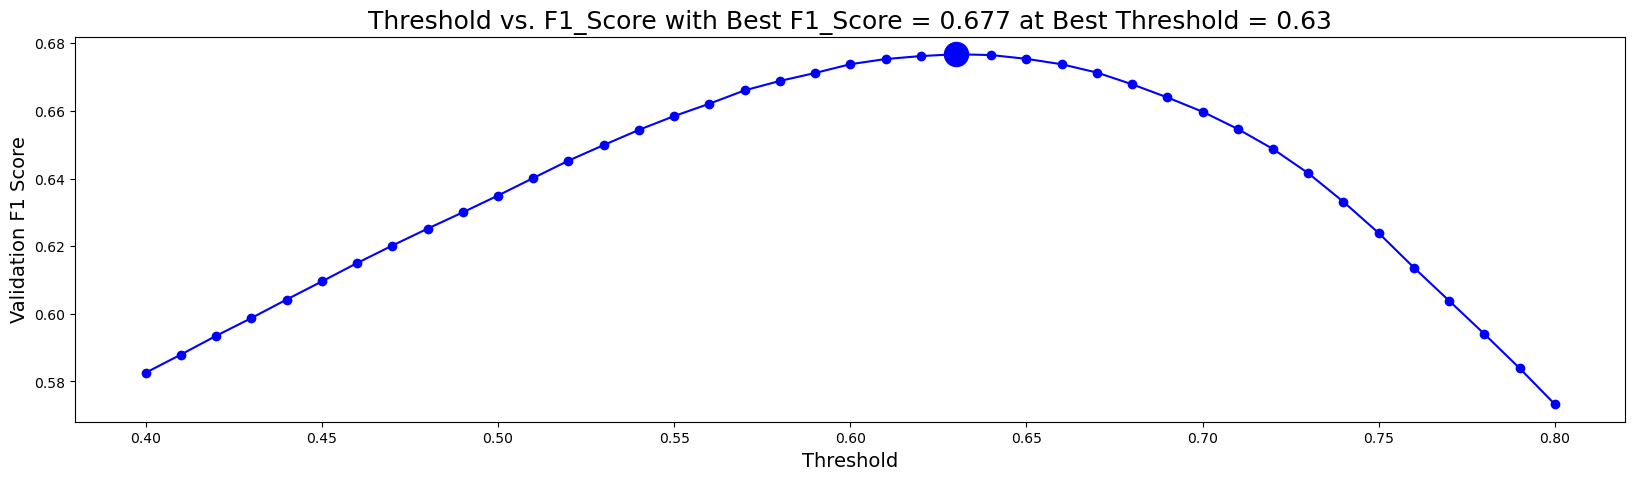

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

# As a result 
We will compute an F1 score for each question and an overall F1 score for all data.

In [14]:
print('Applying the best threshold for each question...')
for k in range(18):   
    
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

Applying the best threshold for each question...
Q0: F1 = 0.5927987485406458
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.4840733291232883
Q3: F1 = 0.5930112681620999
Q4: F1 = 0.5524793212564796
Q5: F1 = 0.5952424931003021
Q6: F1 = 0.573561703066036
Q7: F1 = 0.5400005771747585
Q8: F1 = 0.5931183441267399
Q9: F1 = 0.4757069487495205
Q10: F1 = 0.5869517542888896
Q11: F1 = 0.484444251374067
Q12: F1 = 0.42388048334029965
Q13: F1 = 0.5997858634039993
Q14: F1 = 0.44430586798582516
Q15: F1 = 0.4574626228954524
Q16: F1 = 0.5231336915088703
Q17: F1 = 0.489060663782446
==> Overall F1 = 0.6767516022426934


# Infer Test Data

In [15]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del targets, df, oof, true
_ = gc.collect()

In [16]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


# EDA submission.csv

In [17]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


session_id  correct
0  20090109393214576_q1        1
1  20090109393214576_q2        1
2  20090109393214576_q3        1
3  20090109393214576_q4        1
4  20090109393214576_q5        0

In [18]:
print(df.correct.mean())

0.5925925925925926
